In [1]:
#!pip -q install catboost imbalanced-learn sdv

In [2]:
import os, json, pickle, warnings, time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTEN

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [3]:
MODEL_DIR = "model"
os.makedirs(MODEL_DIR, exist_ok=True)
print("MODEL_DIR:", MODEL_DIR)

MODEL_DIR: model


In [4]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DATA_PATH = "data/devicesPMISMayCat.csv"

TEST_SIZE  = 0.20
VALID_SIZE = 0.20  # valid lấy từ train_temp

# Default input columns (có thể thay đổi động)
# Input có thể là bất kỳ subset nào của ALL_COLS
INPUT_COLS = ["CATEGORYID", "P_MANUFACTURERID", "NATIONALFACT"]
ALL_COLS = [
  'CATEGORYID','P_MANUFACTURERID','DATEMANUFACTURE','NATIONALFACT',
  'OWNER','LOAI','U_TT','KIEU_DAPHQ','I_DM','U_DM','KIEU_CD',
  'TG_CATNM','PHA','KIEU_MC','KNCDNMDM','CT_DC'
]

# Tự động xác định TARGET_COLS từ INPUT_COLS
# TARGET_COLS = các trường trong ALL_COLS không có trong INPUT_COLS
def get_target_cols(input_cols: List[str]) -> List[str]:
    """Get target columns based on input columns."""
    return [c for c in ALL_COLS if c not in input_cols]

TARGET_COLS = get_target_cols(INPUT_COLS)

TOPK = 3
UNK = "UNKNOWN"
OTHER = "OTHER"

# ---------- Auto-fill rules ----------
# Auto-fill rules: target column -> default value
AUTO_FILL_RULES = {
    "PHA": "EVN.PHA_3P",
    "KIEU_MC": "TBI_CT_MC_KIEU_MC_01",
    "KIEU_DAPHQ": "TBI_TT_MC_KIEU_DAPHQ.00001",
    "KIEU_CD": "TBI_CT_MC_CC_CD.00001",
    "U_TT": "TBI_CT_MC_U_TT_02",
}

# ---------- Validation rules ----------
# Invalid NATIONALFACT value that should trigger error
INVALID_NATIONALFACT = "TB040.00023"

# ---------- Augmentation (Soft & Safe) ----------
SOFT_RATIO = 0.40
MIN_SAMPLES_SMOTEN = 5
MIN_SAMPLES_GAN = 15

# CTGAN adaptive epochs (giảm thời gian)
CTGAN_EPOCHS_SMALL = 200   # <=10 classes
CTGAN_EPOCHS_MED   = 100   # 11-30
CTGAN_EPOCHS_LARGE = 50    # >30

CTGAN_POOL_FACTOR = 5

# ---------- Training optimization switches ----------
AUG_BASE = ["raw", "ros", "smoten"]  # luôn chạy (nhanh + hữu ích)
ENABLE_CTGAN = True                  # giữ CTGAN nhưng chạy theo rule
ENABLE_TABTRANSFORMER = True         # chạy chọn lọc để tiết kiệm time

# Rule chạy CTGAN: chỉ khi mất cân bằng nặng hoặc label hiếm nhiều
IMB_THRESHOLD = 0.10          # min/max < 0.10
MAX_CLASSES_FOR_CTGAN = 50

# Rare label grouping: giảm noise, giảm unseen, tăng top3
RARE_MIN_FREQ = 3


In [5]:
df = pd.read_csv(DATA_PATH)

# --- basic cleaning for object ---
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = df[c].astype(str).str.strip()
        df.loc[df[c].isin(["", "nan", "None", "NaN", "NAN"]), c] = np.nan

# DATEMANUFACTURE: đang float nhưng thực tế dạng category => cast string
if "DATEMANUFACTURE" in df.columns:
    df["DATEMANUFACTURE"] = pd.to_numeric(df["DATEMANUFACTURE"], errors="coerce").round().astype("Int64").astype(str)
    df.loc[df["DATEMANUFACTURE"].isin(["<NA>", "nan"]), "DATEMANUFACTURE"] = np.nan

# --- Validation: Check for invalid NATIONALFACT value ---
if "NATIONALFACT" in df.columns:
    invalid_mask = df["NATIONALFACT"].astype(str).str.strip() == INVALID_NATIONALFACT
    if invalid_mask.any():
        invalid_count = invalid_mask.sum()
        invalid_rows = df[invalid_mask].index.tolist()
        error_msg = f"Không có quốc gia Việt Nam hãy nhập lại nhãn này: {INVALID_NATIONALFACT}. Found {invalid_count} row(s) at indices: {invalid_rows[:10]}"
        print(f"⚠️  WARNING: {error_msg}")
        # Remove invalid rows or raise error based on requirement
        # For now, we'll remove them to continue processing
        df = df[~invalid_mask].copy()
        print(f"   Removed {invalid_count} invalid row(s)")

# đảm bảo chỉ lấy các cột cần
df = df[ALL_COLS].copy()

# split test trước (chống leakage)
train_temp, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=SEED, shuffle=True)
train_df, valid_df = train_test_split(train_temp, test_size=VALID_SIZE, random_state=SEED, shuffle=True)

print("Train:", train_df.shape, "Valid:", valid_df.shape, "Test:", test_df.shape)


Train: (722, 16) Valid: (181, 16) Test: (226, 16)


In [6]:
stats = {}
for c in ALL_COLS:
    mode = train_df[c].mode(dropna=True)
    stats[c] = {
        "missing_rate_train": float(train_df[c].isna().mean()),
        "nunique_train": int(train_df[c].nunique(dropna=True)),
        "mode_train": mode.iloc[0] if len(mode) else None
    }

stats_df = pd.DataFrame(stats).T.sort_values(["nunique_train","missing_rate_train"])
stats_df


,missing_rate_train,nunique_train,mode_train
CATEGORYID,0.0,1,0110D00_MC
KIEU_DAPHQ,0.0,1,TBI_TT_MC_KIEU_DAPHQ.00001
PHA,0.0,1,EVN.PHA_3P
CT_DC,0.0,1,TBI_CT_MC_CT_DC_01
OWNER,0.0,2,TB0632
KIEU_CD,0.0,2,TBI_CT_MC_CC_CD.00001
TG_CATNM,0.0,2,PB-100081
KIEU_MC,0.0,2,TBI_CT_MC_KIEU_MC_01
U_TT,0.0,4,TBI_CT_MC_U_TT_01
U_DM,0.0,4,TBI_CT_MC_U_DM_02


In [7]:
class TrainOnlyImputer:
    def __init__(self, unk=UNK):
        self.unk = unk
        self.fill = {}

    def fit(self, df_fit: pd.DataFrame):
        for c in df_fit.columns:
            if df_fit[c].dtype == "object" or str(df_fit[c].dtype).startswith("string"):
                m = df_fit[c].mode(dropna=True)
                self.fill[c] = m.iloc[0] if len(m) else self.unk
            else:
                self.fill[c] = float(df_fit[c].median())
        return self

    def transform(self, df_in: pd.DataFrame):
        out = df_in.copy()
        for c, v in self.fill.items():
            out[c] = out[c].fillna(v)
        return out

imputer = TrainOnlyImputer().fit(train_df[ALL_COLS])


In [8]:
train_imp = imputer.transform(train_df[ALL_COLS])
valid_imp = imputer.transform(valid_df[ALL_COLS])
test_imp  = imputer.transform(test_df[ALL_COLS])

# Create X_train, X_valid, X_test with default INPUT_COLS (for backward compatibility)
X_train = train_imp[INPUT_COLS].astype(str).fillna(UNK)
X_valid = valid_imp[INPUT_COLS].astype(str).fillna(UNK)
X_test  = test_imp[INPUT_COLS].astype(str).fillna(UNK)

# Helper function to get cat_features_idx for any input_cols
def get_cat_features_idx(input_cols: List[str], X: pd.DataFrame) -> List[int]:
    """Get categorical feature indices for given input columns."""
    return [X.columns.get_loc(c) for c in input_cols if c in X.columns]

cat_features_idx = get_cat_features_idx(INPUT_COLS, X_train)


In [9]:
def fit_le_with_unk(s: pd.Series) -> LabelEncoder:
    le = LabelEncoder()
    s = s.astype(str).fillna(UNK)
    le.fit(pd.concat([s, pd.Series([UNK])], ignore_index=True))
    return le

def le_transform_safe(le: LabelEncoder, s: pd.Series) -> np.ndarray:
    s = s.astype(str).fillna(UNK)
    known = set(le.classes_)
    s = s.where(s.isin(known), UNK)
    return le.transform(s)

def filter_unseen_y(y_true: pd.Series, known_classes: List[str]) -> np.ndarray:
    known = set(map(str, known_classes))
    return y_true.astype(str).isin(known).values

def group_rare_labels(ytr, yva, yte, min_freq=RARE_MIN_FREQ):
    vc = ytr.value_counts()
    rare = set(vc[vc < min_freq].index.astype(str))
    def map_y(y):
        y = y.astype(str)
        return y.where(~y.isin(rare), OTHER)
    return map_y(ytr), map_y(yva), map_y(yte)

def unseen_rate_test(ytr, yva, yte):
    known = set(pd.concat([ytr, yva]).astype(str).unique())
    return float(1 - yte.astype(str).isin(known).mean())


In [10]:
def build_task(target_col: str, input_cols: List[str] = None):
    """
    Build task data for a target column.
    
    Args:
        target_col: Target column name
        input_cols: List of input column names. If None, uses INPUT_COLS
    """
    if input_cols is None:
        input_cols = INPUT_COLS
    
    ytr = train_imp[target_col].astype(str)
    yva = valid_imp[target_col].astype(str)
    yte = test_imp[target_col].astype(str)
    
    Xtr = train_imp[input_cols].astype(str).fillna(UNK)
    Xva = valid_imp[input_cols].astype(str).fillna(UNK)
    Xte = test_imp[input_cols].astype(str).fillna(UNK)
    
    return (Xtr, ytr), (Xva, yva), (Xte, yte)

TASKS = {t: build_task(t) for t in TARGET_COLS}


In [11]:
def topk_acc(y_true, proba, classes, k=3):
    idx = np.argsort(-proba, axis=1)[:, :k]
    topk = np.array(classes)[idx]
    return float(np.mean([yt in row for yt, row in zip(y_true, topk)]))

def compute_metrics(y_true, y_pred, proba=None, classes=None):
    out = {
        "acc": float(accuracy_score(y_true, y_pred)) if len(y_true) else np.nan,
        "macro_f1": float(f1_score(y_true, y_pred, average="macro")) if len(y_true) else np.nan
    }
    if proba is not None and classes is not None and proba.shape[1] >= 3 and len(y_true):
        out["top3_acc"] = topk_acc(np.array(y_true), proba, classes, k=3)
    else:
        out["top3_acc"] = np.nan
    if proba is not None and classes is not None and proba.shape[1] >= 2 and len(y_true):
        try:
            out["logloss"] = float(log_loss(y_true, proba, labels=classes))
        except:
            out["logloss"] = np.nan
    else:
        out["logloss"] = np.nan
    return out


In [12]:
def ros_balance_soft(df_in, target, ratio=SOFT_RATIO):
    d = df_in.copy()
    vc = d[target].value_counts()
    max_n = vc.max()
    target_n = int(max_n * ratio)

    parts = []
    for cls, n in vc.items():
        sub = d[d[target] == cls]
        if n < target_n:
            add_n = target_n - n
            add = sub.sample(add_n, replace=True, random_state=SEED)
            parts.append(pd.concat([sub, add], ignore_index=True))
        else:
            parts.append(sub)

    return pd.concat(parts, ignore_index=True).sample(frac=1, random_state=SEED).reset_index(drop=True)

def smoten_balance_safe(df_in, feat_cols, target, ratio=SOFT_RATIO):
    try:
        vc = df_in[target].value_counts()
        max_n = vc.max()
        target_n = int(max_n * ratio)

        strategy = {}
        for cls, n in vc.items():
            if n < target_n:
                if n < MIN_SAMPLES_SMOTEN:
                    return ros_balance_soft(df_in, target, ratio)
                strategy[cls] = target_n

        if not strategy:
            return df_in

        X = df_in[feat_cols].astype(str)
        y = df_in[target].astype(str)

        sm = SMOTEN(random_state=SEED, k_neighbors=3, sampling_strategy=strategy)
        Xr, yr = sm.fit_resample(X, y)

        out = Xr.copy()
        out[target] = yr
        return out.sample(frac=1, random_state=SEED).reset_index(drop=True)
    except:
        return ros_balance_soft(df_in, target, ratio)

def ctgan_epochs_by_classes(n_classes: int) -> int:
    if n_classes <= 10:
        return CTGAN_EPOCHS_SMALL
    if n_classes <= 30:
        return CTGAN_EPOCHS_MED
    return CTGAN_EPOCHS_LARGE

def ctgan_balance_safe(df_in, target, ratio=SOFT_RATIO, pool_factor=CTGAN_POOL_FACTOR):
    try:
        from sdv.single_table import CTGANSynthesizer
        from sdv.metadata import SingleTableMetadata

        d = df_in.copy()
        for c in d.columns:
            d[c] = d[c].astype(str).fillna(UNK)

        vc = d[target].value_counts()
        n_classes = len(vc)
        max_n = vc.max()
        target_n = int(max_n * ratio)

        need = {cls: (target_n - n) for cls, n in vc.items() if n < target_n}
        if not need:
            return d

        # chỉ cho phép GAN nếu class đủ mẫu
        gan_candidates = [cls for cls in need.keys() if vc[cls] >= MIN_SAMPLES_GAN]
        if not gan_candidates:
            return ros_balance_soft(df_in, target, ratio)

        # Fit GAN
        epochs = ctgan_epochs_by_classes(n_classes)
        meta = SingleTableMetadata()
        meta.detect_from_dataframe(d)
        synth = CTGANSynthesizer(meta, epochs=epochs, verbose=False)
        synth.fit(d)

        total_need = sum(need.values())
        pool_n = max(200, int(total_need * pool_factor))
        pool = synth.sample(num_rows=pool_n)

        # Filter pool: chỉ giữ các giá trị input nằm trong train (giảm sinh rác)
        for col in INPUT_COLS:
            if col in pool.columns:
                pool = pool[pool[col].isin(set(d[col].unique()))]

        # Filter mạnh hơn: chỉ giữ combo input đã từng thấy (giảm noise)
        if len(INPUT_COLS) > 0:
            seen_combo = set(zip(*[d[col] for col in INPUT_COLS]))
            pool_combo = list(zip(*[pool[col] for col in INPUT_COLS]))
            pool = pool[np.array([c in seen_combo for c in pool_combo])]

        pool = pool[pool[target].isin(gan_candidates)].copy()

        parts = [d]
        for cls, k in need.items():
            if cls in gan_candidates:
                cand = pool[pool[target] == cls]
                if len(cand) >= k:
                    parts.append(cand.sample(k, random_state=SEED))
                else:
                    parts.append(cand)
                    rem = k - len(cand)
                    if rem > 0:
                        real = d[d[target] == cls]
                        parts.append(real.sample(rem, replace=True, random_state=SEED))
            else:
                real = d[d[target] == cls]
                parts.append(real.sample(k, replace=True, random_state=SEED))

        out = pd.concat(parts, ignore_index=True).sample(frac=1, random_state=SEED).reset_index(drop=True)
        return out

    except:
        return ros_balance_soft(df_in, target, ratio)

def apply_augment_Xy(X: pd.DataFrame, y: pd.Series, augment: str, feat_cols: list):
    df_aug = X.copy()
    df_aug["__y__"] = y.astype(str)

    if augment == "raw":
        out = df_aug
    elif augment == "ros":
        out = ros_balance_soft(df_aug, "__y__")
    elif augment == "smoten":
        out = smoten_balance_safe(df_aug, feat_cols, "__y__")
    elif augment == "ctgan":
        out = ctgan_balance_safe(df_aug, "__y__")
    else:
        raise ValueError("augment must be raw|ros|smoten|ctgan")

    y_out = out["__y__"].copy()
    X_out = out.drop(columns=["__y__"])
    return X_out, y_out

print("✅ Augmentation helpers ready")


✅ Augmentation helpers ready


In [13]:
def generate_backoff_strategy(input_cols: List[str]) -> List[List[str]]:
    """
    Generate backoff strategy based on input columns.
    Creates all possible subsets of input_cols in order of decreasing size.
    """
    from itertools import combinations
    
    n = len(input_cols)
    backoffs = []
    
    # Add all subsets from size n down to 0
    for r in range(n, -1, -1):
        if r == 0:
            backoffs.append([])  # Global fallback
        else:
            # Add all combinations of size r
            for combo in combinations(input_cols, r):
                backoffs.append(list(combo))
    
    return backoffs

class TransitionTable:
    def __init__(self, alpha=1.0, input_cols=None):
        self.alpha = alpha
        self.classes = None
        self.counts = None
        self.input_cols = input_cols  # Store input_cols for prediction
        self.backoffs = None  # Store backoff strategy

    def fit(self, X, y, input_cols=None):
        """
        Fit TransitionTable model.
        
        Args:
            X: Input features DataFrame
            y: Target Series
            input_cols: List of input column names. If None, uses X.columns
        """
        y = y.astype(str).reset_index(drop=True)
        X = X.reset_index(drop=True)
        self.classes = sorted(y.unique().tolist())
        
        # Determine input_cols
        if input_cols is None:
            if self.input_cols is None:
                self.input_cols = list(X.columns)
            else:
                input_cols = self.input_cols
        else:
            self.input_cols = input_cols
        
        # Ensure all input_cols exist in X
        missing_cols = [c for c in self.input_cols if c not in X.columns]
        if missing_cols:
            raise ValueError(f"Input columns not found in X: {missing_cols}")
        
        # Generate backoff strategy based on input_cols
        self.backoffs = generate_backoff_strategy(self.input_cols)
        self.counts = {tuple(b): {} for b in self.backoffs}

        for i in range(len(X)):
            row = X.loc[i]
            for b in self.backoffs:
                k = tuple(b)
                feat_key = tuple(row[c] for c in b) if b else ("__GLOBAL__",)
                d = self.counts[k].setdefault(feat_key, {})
                d[y[i]] = d.get(y[i], 0) + 1
        return self

    def predict_proba_one(self, xrow):
        """Predict probability for a single row."""
        if self.backoffs is None:
            raise ValueError("Model not fitted. Call fit() first.")
        
        for b in self.backoffs:
            k = tuple(b)
            feat_key = tuple(xrow[c] for c in b) if b else ("__GLOBAL__",)
            if feat_key in self.counts[k]:
                counts = self.counts[k][feat_key]
                denom = sum(counts.values()) + self.alpha * len(self.classes)
                return np.array([(counts.get(c,0)+self.alpha)/denom for c in self.classes], dtype=float)
        return np.ones(len(self.classes))/len(self.classes)

    def predict_proba(self, X):
        rows = X.to_dict(orient="records")
        return np.vstack([self.predict_proba_one(r) for r in rows])

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.array(self.classes)[np.argmax(proba, axis=1)]
    
    def predict_topk(self, X: pd.DataFrame, k: int = 3) -> List[List[str]]:
        """Predict top-k classes for each row."""
        proba = self.predict_proba(X)
        topk_idx = np.argsort(-proba, axis=1)[:, :k]
        return [[self.classes[j] for j in row] for row in topk_idx]


In [14]:
def train_catboost(Xtr, ytr, Xva, yva, input_cols=None):
    """Train CatBoost model with relaxed checks so it trains more often.
    
    Args:
        Xtr: Training features DataFrame
        ytr: Training target Series
        Xva: Validation features DataFrame
        yva: Validation target Series
        input_cols: List of input column names. If None, uses Xtr.columns
    
    Returns:
        Trained CatBoost model (with attribute `_y_enc`), or None if data is invalid.
    """
    if input_cols is None:
        input_cols = list(Xtr.columns)

    # Encode target labels to strings
    ytr_str = ytr.astype(str).reset_index(drop=True)
    yva_str = yva.astype(str).reset_index(drop=True)

    # Only require at least 2 classes in train set
    if ytr_str.nunique() < 2:
        return None

    # Require minimal number of samples
    if len(Xtr) < 2:
        return None

    # Categorical feature indices
    cat_features_idx = get_cat_features_idx(input_cols, Xtr)
    if len(cat_features_idx) == 0:
        cat_features_idx = None

    # Label encoding - only fit on training labels to avoid unseen classes in validation
    y_enc = LabelEncoder()
    y_enc.fit(ytr_str)
    ytr_enc = y_enc.transform(ytr_str)
    
    # Filter validation set to only include classes seen in training
    seen_classes = set(y_enc.classes_)
    val_mask = yva_str.isin(seen_classes)

    try:
        if not val_mask.any():
            # No valid validation samples - skip eval_set
            Xtr_fit = Xtr.reset_index(drop=True)
            
            model = CatBoostClassifier(
                loss_function="MultiClass",
                random_seed=SEED,
                verbose=False,
                depth=6,
                learning_rate=0.1,
                iterations=1000,
                od_type="Iter",
                od_wait=50,
                l2_leaf_reg=3.0,
                allow_writing_files=False
            )
            model.fit(
                Xtr_fit,
                ytr_enc,
                cat_features=cat_features_idx,
            )
        else:
            # Filter validation set
            Xva_filtered = Xva[val_mask].reset_index(drop=True)
            yva_filtered = yva_str[val_mask].reset_index(drop=True)
            yva_enc = y_enc.transform(yva_filtered)
            
            Xtr_fit = Xtr.reset_index(drop=True)
            Xva_fit = Xva_filtered

            model = CatBoostClassifier(
                loss_function="MultiClass",
                random_seed=SEED,
                verbose=False,
                depth=6,
                learning_rate=0.1,
                iterations=1000,
                od_type="Iter",
                od_wait=50,
                l2_leaf_reg=3.0,
                allow_writing_files=False
            )
            model.fit(
                Xtr_fit,
                ytr_enc,
                eval_set=(Xva_fit, yva_enc),
                cat_features=cat_features_idx,
                use_best_model=True,
            )
        model._y_enc = y_enc
        model._classes = y_enc.classes_.tolist()
        return model
    except Exception as e:
        import traceback
        print(f"[WARN] CatBoost training failed (relaxed): {e}")
        print(traceback.format_exc())
        return None


In [15]:
class MiniTabTransformer(nn.Module):
    def __init__(self, cardinals, n_classes, d_model=32, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, d_model) for c in cardinals])
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.head = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        toks = torch.stack([self.embs[i](x[:, i]) for i in range(x.shape[1])], dim=1)  # (bs,3,d)
        z = self.encoder(toks)
        pooled = z.mean(dim=1)
        return self.head(pooled)

def fit_tabtransformer_safe(Xtr, ytr, Xva, yva, epochs=15, bs=128, lr=1e-3, input_cols=None):
    """
    Fit TabTransformer model.
    
    Args:
        Xtr: Training features DataFrame
        ytr: Training target Series
        Xva: Validation features DataFrame
        yva: Validation target Series
        epochs: Number of training epochs
        bs: Batch size
        lr: Learning rate
        input_cols: List of input column names. If None, uses Xtr.columns
    """
    if input_cols is None:
        input_cols = list(Xtr.columns)
    
    x_enc = {c: fit_le_with_unk(pd.concat([Xtr[c], Xva[c]])) for c in input_cols}

    y_enc = LabelEncoder()
    y_enc.fit(pd.concat([ytr, yva]).astype(str))

    cardinals = [len(x_enc[c].classes_) for c in input_cols]
    n_classes = len(y_enc.classes_)

    class TabDatasetSafe(Dataset):
        def __init__(self, X, y, input_cols_list):
            self.X = X.reset_index(drop=True).astype(str)
            self.y = y.reset_index(drop=True).astype(str)
            self.input_cols_list = input_cols_list
            self.Xi = np.stack([le_transform_safe(x_enc[c], self.X[c]) for c in input_cols_list], axis=1).astype(np.int64)
            self.yi = y_enc.transform(self.y).astype(np.int64)

        def __len__(self): return len(self.Xi)
        def __getitem__(self, idx):
            return torch.tensor(self.Xi[idx]), torch.tensor(self.yi[idx])

    tr_ds = TabDatasetSafe(Xtr, ytr, input_cols)
    va_ds = TabDatasetSafe(Xva, yva, input_cols)
    tr_loader = DataLoader(tr_ds, batch_size=bs, shuffle=True)
    va_loader = DataLoader(va_ds, batch_size=bs, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MiniTabTransformer(cardinals, n_classes).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    best_acc = -1
    best_state = None

    for ep in range(1, epochs+1):
        model.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in va_loader:
                xb = xb.to(device)
                logits = model(xb).cpu().numpy()
                preds.append(np.argmax(logits, axis=1))
                trues.append(yb.numpy())
        preds = np.concatenate(preds); trues = np.concatenate(trues)
        acc = (preds == trues).mean()

        if acc > best_acc:
            best_acc = acc
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, x_enc, y_enc

def tabtransformer_predict_proba_safe(model, x_enc, y_enc, X, input_cols=None):
    """
    Predict probabilities using TabTransformer model.
    
    Args:
        model: Trained TabTransformer model
        x_enc: Dictionary of LabelEncoders for input columns
        y_enc: LabelEncoder for target
        X: Input DataFrame
        input_cols: List of input column names. If None, uses x_enc.keys()
    """
    if input_cols is None:
        input_cols = list(x_enc.keys())
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X = X.astype(str)
    Xi = np.stack([le_transform_safe(x_enc[c], X[c]) for c in input_cols], axis=1).astype(np.int64)
    xb = torch.tensor(Xi).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(xb).cpu().numpy()
        proba = np.exp(logits - logits.max(axis=1, keepdims=True))
        proba = proba / proba.sum(axis=1, keepdims=True)

    return proba, y_enc.classes_.tolist()


In [16]:
trainvalid_imp = pd.concat([train_imp, valid_imp], axis=0).reset_index(drop=True)
X_trainvalid = trainvalid_imp[INPUT_COLS].astype(str).fillna(UNK)

def get_cv(y: pd.Series, n_splits=5):
    y = y.astype(str)
    vc = y.value_counts()
    if vc.min() >= n_splits:
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED), "stratified"
    return KFold(n_splits=n_splits, shuffle=True, random_state=SEED), "kfold"

def cv_catboost(target, n_splits=5, input_cols=None):
    """
    Cross-validation for CatBoost model.
    
    Args:
        target: Target column name
        n_splits: Number of CV splits
        input_cols: List of input column names. If None, uses INPUT_COLS
    """
    if input_cols is None:
        input_cols = INPUT_COLS
    
    y = trainvalid_imp[target].astype(str)
    X_trainvalid_cv = trainvalid_imp[input_cols].astype(str).fillna(UNK)
    splitter, mode = get_cv(y, n_splits=n_splits)

    accs, f1s = [], []
    for tr_idx, va_idx in splitter.split(X_trainvalid_cv, y if mode=="stratified" else None):
        Xtr, Xva = X_trainvalid_cv.iloc[tr_idx], X_trainvalid_cv.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]

        # Get seen classes from training set
        seen_classes = set(ytr.unique())
        
        # Filter validation set to only include seen classes
        mask = yva.isin(seen_classes)
        if not mask.any():
            # Skip if no valid samples in validation set
            continue
            
        Xva_filtered = Xva[mask]
        yva_filtered = yva[mask]
        
        # Train model (use filtered validation for eval_set to avoid CatBoost error)
        m = train_catboost(Xtr, ytr, Xva_filtered, yva_filtered, input_cols=input_cols)
        if m is None:
            # CatBoost failed (e.g., all features constant) - skip this fold
            continue
        proba = m.predict_proba(Xva_filtered)
        # Lấy lại classes gốc từ label encoder (string labels)
        if hasattr(m, "_classes"):
            cls = m._classes
        elif hasattr(m, "_y_enc"):
            cls = m._y_enc.classes_.tolist()
        else:
            cls = m.classes_.tolist()
            if len(cls) > 0 and isinstance(cls[0], (int, np.integer)):
                # Nếu là integer, không thể map - skip fold này
                continue
        pred_indices = np.argmax(proba, axis=1)
        pred = np.array([cls[i] for i in pred_indices])
        accs.append(accuracy_score(yva_filtered, pred))
        f1s.append(f1_score(yva_filtered, pred, average="macro"))

    if len(accs) == 0:
        return {
            "target": target,
            "cv_mode": mode,
            "cv_acc_mean": np.nan,
            "cv_acc_std": np.nan,
            "cv_f1_mean": np.nan,
            "cv_f1_std": np.nan,
        }

    return {
        "target": target,
        "cv_mode": mode,
        "cv_acc_mean": float(np.mean(accs)),
        "cv_acc_std": float(np.std(accs)),
        "cv_f1_mean": float(np.mean(f1s)),
        "cv_f1_std": float(np.std(f1s)),
    }


In [17]:
def imbalance_ratio(y: pd.Series):
    vc = y.value_counts()
    return float(vc.min() / vc.max())

def should_run_ctgan(y: pd.Series):
    vc = y.value_counts()
    if len(vc) > MAX_CLASSES_FOR_CTGAN:
        return False
    if vc.min() < MIN_SAMPLES_GAN:
        return False
    return (vc.min() / vc.max()) < IMB_THRESHOLD

results = []
best_pack = {}

unseen_rows = []
for t in TARGET_COLS:
    (Xtr, ytr), (Xva, yva), (Xte, yte) = TASKS[t]
    unseen_rows.append([t, stats[t]["nunique_train"], unseen_rate_test(ytr, yva, yte)])
unseen_df = pd.DataFrame(unseen_rows, columns=["target","nunique_train","unseen_rate_test"]).sort_values("unseen_rate_test", ascending=False)
print("Top unseen targets:\n", unseen_df.head(10))

for t in TARGET_COLS:
    nunq = stats[t]["nunique_train"]
    (Xtr, ytr), (Xva, yva), (Xte, yte) = TASKS[t]

    # Auto-fill: Check if target is in AUTO_FILL_RULES
    if t in AUTO_FILL_RULES:
        fill_value = AUTO_FILL_RULES[t]
        results.append({"target": t, "augment": "NA", "model": "AUTO_FILL",
                        "acc": 1.0, "macro_f1": 1.0, "top3_acc": np.nan, "logloss": np.nan})
        best_pack[t] = {"kind": "AUTO_FILL", "fill_value": fill_value, "nunique_train": nunq}
        continue
    
    # nunique=1 => auto-fill (fallback for other columns)
    if nunq <= 1:
        results.append({"target": t, "augment": "NA", "model": "AUTO_FILL",
                        "acc": 1.0, "macro_f1": 1.0, "top3_acc": np.nan, "logloss": np.nan})
        best_pack[t] = {"kind": "AUTO_FILL", "fill_value": stats[t]["mode_train"], "nunique_train": nunq}
        continue

    # nunique 2-3 => TransitionTable cho UI
    if nunq <= 3:
        # Get input_cols from Xtr columns
        input_cols_list = list(Xtr.columns)
        m = TransitionTable(alpha=1.0, input_cols=input_cols_list).fit(pd.concat([Xtr, Xva]), pd.concat([ytr, yva]), input_cols=input_cols_list)
        proba = m.predict_proba(Xte)
        pred = m.predict(Xte)
        mask = filter_unseen_y(yte, m.classes)
        met = compute_metrics(yte[mask], pred[mask], proba[mask], m.classes) if mask.any() else \
              {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
        results.append({"target": t, "augment": "raw", "model": "TransitionTable_UI", **met})
        best_pack[t] = {"kind": "TransitionTable", "model": m, "classes": m.classes, "nunique_train": nunq, "input_cols": input_cols_list}
        continue

    # nunique >3 => train full candidates (raw/ros/smoten luôn có)
    best_score = (-1, -1)
    best_obj = None
    best_catboost = None  # track để quyết định chạy TabTransformer

    # Get input_cols from Xtr columns
    input_cols_list = list(Xtr.columns)
    
    for aug in AUG_BASE:
        Xtr_aug, ytr_aug = apply_augment_Xy(Xtr, ytr, aug, input_cols_list)

        # rare grouping (giảm noise)
        ytr_g, yva_g, yte_g = group_rare_labels(ytr_aug, yva, yte, min_freq=RARE_MIN_FREQ)

        # 1) TransitionTable
        m1 = TransitionTable(alpha=1.0, input_cols=input_cols_list).fit(Xtr_aug, ytr_g, input_cols=input_cols_list)
        p1 = m1.predict_proba(Xte); pr1 = m1.predict(Xte)
        mask1 = filter_unseen_y(yte_g, m1.classes)
        met1 = compute_metrics(yte_g[mask1], pr1[mask1], p1[mask1], m1.classes) if mask1.any() else \
               {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
        results.append({"target": t, "augment": aug, "model": "TransitionTable", **met1})

        # 2) CatBoost
        m2 = train_catboost(Xtr_aug, ytr_g, Xva, yva_g, input_cols=input_cols_list)
        if m2 is None:
            # CatBoost failed (e.g., all features constant) - skip and use TransitionTable results only
            met2 = {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
            cls2 = []
            results.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
        else:
            try:
                p2 = m2.predict_proba(Xte)
                # Lấy lại classes gốc từ label encoder (string labels)
                if hasattr(m2, "_classes"):
                    cls2 = m2._classes  # String labels gốc
                elif hasattr(m2, "_y_enc"):
                    cls2 = m2._y_enc.classes_.tolist()  # String labels từ encoder
                else:
                    # Fallback: nếu không có encoder, dùng classes_ (có thể là integer)
                    cls2 = m2.classes_.tolist()
                    # Nếu là integer, cần map lại - nhưng trường hợp này không nên xảy ra
                    if len(cls2) > 0 and isinstance(cls2[0], (int, np.integer)):
                        print(f"[WARN] CatBoost model for {t} has integer classes, cannot map to string labels")
                        cls2 = []
                
                if len(cls2) == 0:
                    met2 = {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
                    results.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
                else:
                    # Map predictions từ integer indices về string labels
                    pred_indices = np.argmax(p2, axis=1)
                    pr2 = np.array([cls2[i] for i in pred_indices])
                    # Với CatBoost, dùng toàn bộ yte_g để tính metric (không filter unseen)
                    met2 = compute_metrics(yte_g, pr2, p2, cls2)
                    results.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
            except Exception as e:
                import traceback
                print(f"[ERROR] CatBoost prediction failed for {t} with {aug}: {str(e)}")
                print(f"[ERROR] Traceback: {traceback.format_exc()}")
                met2 = {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
                cls2 = []
                results.append({"target": t, "augment": aug, "model": "CatBoost", **met2})

        # update best global
        for met, obj in [
            (met1, {"kind":"TransitionTable","model":m1,"classes":m1.classes,"augment":aug, "rare_min_freq": RARE_MIN_FREQ, "input_cols": input_cols_list}),
        ]:
            if np.isnan(met["macro_f1"]):
                continue
            score = (met["macro_f1"], met["top3_acc"] if not np.isnan(met["top3_acc"]) else -1)
            if score > best_score:
                best_score = score
                best_obj = obj
        
        # Only update CatBoost best if model trained successfully
        if m2 is not None:
            for met, obj in [
                (met2, {"kind":"CatBoost","model":m2,"classes":cls2,"augment":aug, "rare_min_freq": RARE_MIN_FREQ, "input_cols": input_cols_list})
            ]:
                if np.isnan(met["macro_f1"]):
                    continue
                score = (met["macro_f1"], met["top3_acc"] if not np.isnan(met["top3_acc"]) else -1)
                if score > best_score:
                    best_score = score
                    best_obj = obj

            # track best catboost score
            if (best_catboost is None) or ((met2["macro_f1"], met2["top3_acc"] if not np.isnan(met2["top3_acc"]) else -1) >
                                           (best_catboost["met"]["macro_f1"], best_catboost["met"]["top3_acc"] if not np.isnan(best_catboost["met"]["top3_acc"]) else -1)):
                best_catboost = {"met": met2, "augment": aug}

    # CTGAN (giữ CTGAN nhưng chạy theo rule để tiết kiệm time mà không giảm acc)
    if ENABLE_CTGAN and should_run_ctgan(ytr):
        aug = "ctgan"
        Xtr_aug, ytr_aug = apply_augment_Xy(Xtr, ytr, aug, input_cols_list)
        ytr_g, yva_g, yte_g = group_rare_labels(ytr_aug, yva, yte, min_freq=RARE_MIN_FREQ)

        m2 = train_catboost(Xtr_aug, ytr_g, Xva, yva_g, input_cols=input_cols_list)
        if m2 is None:
            # CatBoost failed (e.g., all features constant) - skip CTGAN CatBoost
            met2 = {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
            cls2 = []
            results.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
        else:
            try:
                p2 = m2.predict_proba(Xte)
                # Lấy lại classes gốc từ label encoder (string labels)
                if hasattr(m2, "_classes"):
                    cls2 = m2._classes
                elif hasattr(m2, "_y_enc"):
                    cls2 = m2._y_enc.classes_.tolist()
                else:
                    cls2 = m2.classes_.tolist()
                    if len(cls2) > 0 and isinstance(cls2[0], (int, np.integer)):
                        print(f"[WARN] CTGAN CatBoost model for {t} has integer classes")
                        cls2 = []
                
                if len(cls2) == 0:
                    met2 = {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
                    results.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
                else:
                    pred_indices = np.argmax(p2, axis=1)
                    pr2 = np.array([cls2[i] for i in pred_indices])
                    mask2 = filter_unseen_y(yte_g, cls2)
                    met2 = compute_metrics(yte_g[mask2], pr2[mask2], p2[mask2], cls2) if mask2.any() else \
                           {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
                    results.append({"target": t, "augment": aug, "model": "CatBoost", **met2})

                    score = (met2["macro_f1"], met2["top3_acc"] if not np.isnan(met2["top3_acc"]) else -1)
                    if not np.isnan(met2["macro_f1"]) and score > best_score:
                        best_score = score
                        best_obj = {"kind":"CatBoost","model":m2,"classes":cls2,"augment":aug, "rare_min_freq": RARE_MIN_FREQ, "input_cols": input_cols_list}
            except Exception as e:
                import traceback
                print(f"[ERROR] CTGAN CatBoost prediction failed for {t}: {str(e)}")
                met2 = {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
                cls2 = []
                results.append({"target": t, "augment": aug, "model": "CatBoost", **met2})

    # TabTransformer: chạy chọn lọc (khi CatBoost không hơn TransitionTable đáng kể)
    if ENABLE_TABTRANSFORMER and best_catboost is not None:
        # tìm best TransitionTable theo results của target này để so sánh nhanh
        df_t = pd.DataFrame([r for r in results if r["target"]==t])
        best_tt_f1 = df_t[df_t["model"].str.contains("TransitionTable")]["macro_f1"].max()
        cb_f1 = best_catboost["met"]["macro_f1"]

        if (not np.isnan(best_tt_f1)) and (not np.isnan(cb_f1)) and (cb_f1 < best_tt_f1 + 0.01):
            aug = best_catboost["augment"]
            Xtr_aug, ytr_aug = apply_augment_Xy(Xtr, ytr, aug, input_cols_list)
            ytr_g, yva_g, yte_g = group_rare_labels(ytr_aug, yva, yte, min_freq=RARE_MIN_FREQ)

            m3, xenc, yenc = fit_tabtransformer_safe(Xtr_aug, ytr_g, Xva, yva_g, epochs=15, input_cols=input_cols_list)
            p3, cls3 = tabtransformer_predict_proba_safe(m3, xenc, yenc, Xte, input_cols=input_cols_list)
            pr3 = np.array(cls3)[np.argmax(p3, axis=1)]
            mask3 = filter_unseen_y(yte_g, cls3)
            met3 = compute_metrics(yte_g[mask3], pr3[mask3], p3[mask3], cls3) if mask3.any() else \
                   {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
            results.append({"target": t, "augment": aug, "model": "TabTransformer", **met3})

            score = (met3["macro_f1"], met3["top3_acc"] if not np.isnan(met3["top3_acc"]) else -1)
            if not np.isnan(met3["macro_f1"]) and score > best_score:
                best_score = score
                best_obj = {"kind":"TabTransformer","model":m3,"classes":cls3,"augment":aug,
                            "extra":{"x_enc":xenc,"y_enc":yenc}, "rare_min_freq": RARE_MIN_FREQ, "input_cols": input_cols_list}

    # Ensure best_obj is not None (fallback to TransitionTable if all models failed)
    if best_obj is None:
        # Fallback: use TransitionTable with raw augmentation
        Xtr_aug, ytr_aug = apply_augment_Xy(Xtr, ytr, "raw", input_cols_list)
        ytr_g, yva_g, yte_g = group_rare_labels(ytr_aug, yva, yte, min_freq=RARE_MIN_FREQ)
        m1 = TransitionTable(alpha=1.0, input_cols=input_cols_list).fit(Xtr_aug, ytr_g, input_cols=input_cols_list)
        best_obj = {"kind":"TransitionTable","model":m1,"classes":m1.classes,"augment":"raw", "rare_min_freq": RARE_MIN_FREQ, "input_cols": input_cols_list}
    
    best_obj["nunique_train"] = nunq
    best_pack[t] = best_obj

res_df = pd.DataFrame(results).sort_values(["target","macro_f1"], ascending=[True, False])
res_df

Top unseen targets:
              target  nunique_train  unseen_rate_test
2              LOAI              6          0.004425
10          KIEU_MC              2          0.004425
0   DATEMANUFACTURE             30          0.000000
3              U_TT              4          0.000000
1             OWNER              2          0.000000
4        KIEU_DAPHQ              1          0.000000
5              I_DM              5          0.000000
7           KIEU_CD              2          0.000000
6              U_DM              4          0.000000
8          TG_CATNM              2          0.000000
[WARN] CatBoost training failed (relaxed): Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).
Traceback (most recent call last):
  File "/tmp/ipykernel_226869/1280023549.py", line 67, in train_catboost
    Xva_filtered = Xva[val_mask].reset_index(drop=True)
  File "/home/aispcit/Documents/QuangLV/.venv/lib/python3.9/site-package

,target,augment,model,acc,macro_f1,top3_acc,logloss
37,CT_DC,NA,AUTO_FILL,1.000000,1.000000,NaN,NaN
0,DATEMANUFACTURE,raw,TransitionTable,0.320000,0.179274,0.635556,2.351147
2,DATEMANUFACTURE,ros,TransitionTable,0.240000,0.167609,0.564444,2.439628
4,DATEMANUFACTURE,smoten,TransitionTable,0.240000,0.167609,0.564444,2.439628
1,DATEMANUFACTURE,raw,CatBoost,NaN,NaN,NaN,NaN
3,DATEMANUFACTURE,ros,CatBoost,NaN,NaN,NaN,NaN
5,DATEMANUFACTURE,smoten,CatBoost,NaN,NaN,NaN,NaN
17,I_DM,ros,TransitionTable,0.601770,0.464660,0.955752,0.852768
19,I_DM,smoten,TransitionTable,0.606195,0.456706,0.955752,0.803604
15,I_DM,raw,TransitionTable,0.774336,0.302901,0.982301,0.631805


In [18]:
cv_rows = []
for t in TARGET_COLS:
    if best_pack[t]["kind"] == "CatBoost":
        cv_rows.append(cv_catboost(t, n_splits=5))

cv_df = pd.DataFrame(cv_rows)
if len(cv_df) > 0 and "cv_f1_mean" in cv_df.columns:
    cv_df = cv_df.sort_values("cv_f1_mean", ascending=False)
cv_df


""


In [19]:
# Lấy best result theo target từ res_df để report
best_rows = []
for t in TARGET_COLS:
    nunq = stats[t]["nunique_train"]
    # Check if target is in AUTO_FILL_RULES (auto-fill with fixed values)
    if t in AUTO_FILL_RULES:
        best_rows.append([t, nunq, "AUTO_FILL", "NA", 1.0, 1.0, np.nan])
        continue
    # Check if nunique <= 1 (fallback auto-fill)
    if nunq <= 1:
        best_rows.append([t, nunq, "AUTO_FILL", "NA", 1.0, 1.0, np.nan])
        continue
    if nunq <= 3:
        # lấy dòng TransitionTable_UI
        r = res_df[(res_df["target"]==t) & (res_df["model"]=="TransitionTable_UI")].head(1)
        if len(r):
            best_rows.append([t, nunq, "TransitionTable_UI", "raw", float(r["acc"].iloc[0]), float(r["macro_f1"].iloc[0]), float(r["top3_acc"].iloc[0]) if pd.notna(r["top3_acc"].iloc[0]) else np.nan])
        else:
            best_rows.append([t, nunq, "TransitionTable_UI", "raw", np.nan, np.nan, np.nan])
        continue

    kind = best_pack[t]["kind"]
    aug  = best_pack[t]["augment"]
    # best entry trong res_df tương ứng
    r = res_df[(res_df["target"]==t) & (res_df["model"].str.contains(kind)) & (res_df["augment"]==aug)].head(1)
    if len(r)==0:
        # fallback: lấy dòng macro_f1 cao nhất
        r = res_df[(res_df["target"]==t)].sort_values("macro_f1", ascending=False).head(1)
    best_rows.append([t, nunq, kind, aug, float(r["acc"].iloc[0]), float(r["macro_f1"].iloc[0]), float(r["top3_acc"].iloc[0]) if pd.notna(r["top3_acc"].iloc[0]) else np.nan])

report_df = pd.DataFrame(best_rows, columns=["target","nunique_train","best_kind","best_aug","acc","macro_f1","top3_acc"])

def grade(row):
    # Check if target is in AUTO_FILL_RULES or nunique <= 1
    if row["target"] in AUTO_FILL_RULES or row["nunique_train"] <= 1:
        return "AUTO"
    if row["nunique_train"] <= 3:
        return "OK" if row["macro_f1"]>=0.65 else "NEED_IMPROVE"
    # nunique >3 => ưu tiên top3
    if pd.isna(row["top3_acc"]):
        return "NEED_IMPROVE"
    if row["top3_acc"] >= 0.90: return "EXCELLENT"
    if row["top3_acc"] >= 0.80: return "GOOD"
    if row["top3_acc"] >= 0.70: return "PASS"
    return "NEED_IMPROVE"

report_df["grade"] = report_df.apply(grade, axis=1)
report_df.sort_values(["grade","top3_acc"], ascending=[True, False])


,target,nunique_train,best_kind,best_aug,acc,macro_f1,top3_acc,grade
3,U_TT,4,AUTO_FILL,NA,1.000000,1.000000,NaN,AUTO
4,KIEU_DAPHQ,1,AUTO_FILL,NA,1.000000,1.000000,NaN,AUTO
7,KIEU_CD,2,AUTO_FILL,NA,1.000000,1.000000,NaN,AUTO
9,PHA,1,AUTO_FILL,NA,1.000000,1.000000,NaN,AUTO
10,KIEU_MC,2,AUTO_FILL,NA,1.000000,1.000000,NaN,AUTO
12,CT_DC,1,AUTO_FILL,NA,1.000000,1.000000,NaN,AUTO
6,U_DM,4,TransitionTable,raw,0.827434,0.764250,1.000000,EXCELLENT
2,LOAI,6,TransitionTable,raw,0.924444,0.829460,0.995556,EXCELLENT
11,KNCDNMDM,5,TransitionTable,raw,0.800885,0.343750,0.982301,EXCELLENT
5,I_DM,5,TransitionTable,ros,0.601770,0.464660,0.955752,EXCELLENT


In [20]:
# ============================================================================
# HÀM HELPER ĐỂ TRAIN MODEL VỚI INPUT_COLS ĐỘNG
# ============================================================================
# Bây giờ bạn có thể train model với bất kỳ input_cols nào (2, 3, 4, hoặc nhiều hơn)
# TARGET_COLS sẽ tự động được xác định = ALL_COLS - INPUT_COLS

def train_with_dynamic_input(input_cols: List[str], save_models: bool = True):
    """
    Train models với input_cols động.
    
    Args:
        input_cols: List các trường input (có thể là 2, 3, 4 hoặc bất kỳ số trường nào)
        save_models: Có lưu models không
    
    Returns:
        best_pack: Dictionary chứa các models đã train
    """
    # Validate input_cols
    invalid_cols = [c for c in input_cols if c not in ALL_COLS]
    if invalid_cols:
        raise ValueError(f"Invalid input columns: {invalid_cols}. Available columns: {ALL_COLS}")
    
    # Tự động xác định TARGET_COLS
    target_cols = get_target_cols(input_cols)
    print(f"Input columns: {input_cols}")
    print(f"Target columns: {target_cols}")
    print(f"Number of input columns: {len(input_cols)}")
    print(f"Number of target columns: {len(target_cols)}")
    
    # Build tasks với input_cols mới
    tasks = {t: build_task(t, input_cols=input_cols) for t in target_cols}
    
    # Train models
    results = []
    best_pack_dynamic = {}
    
    for t in target_cols:
        nunq = stats[t]["nunique_train"]
        (Xtr, ytr), (Xva, yva), (Xte, yte) = tasks[t]
        
        # Auto-fill: Check if target is in AUTO_FILL_RULES
        if t in AUTO_FILL_RULES:
            fill_value = AUTO_FILL_RULES[t]
            results.append({"target": t, "augment": "NA", "model": "AUTO_FILL",
                            "acc": 1.0, "macro_f1": 1.0, "top3_acc": np.nan, "logloss": np.nan})
            best_pack_dynamic[t] = {"kind": "AUTO_FILL", "fill_value": fill_value, "nunique_train": nunq, "input_cols": input_cols}
            continue
        
        # nunique=1 => auto-fill
        if nunq <= 1:
            results.append({"target": t, "augment": "NA", "model": "AUTO_FILL",
                            "acc": 1.0, "macro_f1": 1.0, "top3_acc": np.nan, "logloss": np.nan})
            best_pack_dynamic[t] = {"kind": "AUTO_FILL", "fill_value": stats[t]["mode_train"], "nunique_train": nunq, "input_cols": input_cols}
            continue
        
        # nunique 2-3 => TransitionTable
        if nunq <= 3:
            m = TransitionTable(alpha=1.0, input_cols=input_cols).fit(pd.concat([Xtr, Xva]), pd.concat([ytr, yva]), input_cols=input_cols)
            proba = m.predict_proba(Xte)
            pred = m.predict(Xte)
            mask = filter_unseen_y(yte, m.classes)
            met = compute_metrics(yte[mask], pred[mask], proba[mask], m.classes) if mask.any() else \
                  {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
            results.append({"target": t, "augment": "raw", "model": "TransitionTable_UI", **met})
            best_pack_dynamic[t] = {"kind": "TransitionTable", "model": m, "classes": m.classes, "nunique_train": nunq, "input_cols": input_cols}
            continue
        
        # nunique >3 => train full candidates
        best_score = (-1, -1)
        best_obj = None
        
        for aug in AUG_BASE:
            Xtr_aug, ytr_aug = apply_augment_Xy(Xtr, ytr, aug, input_cols)
            ytr_g, yva_g, yte_g = group_rare_labels(ytr_aug, yva, yte, min_freq=RARE_MIN_FREQ)
            
            # TransitionTable
            m1 = TransitionTable(alpha=1.0, input_cols=input_cols).fit(Xtr_aug, ytr_g, input_cols=input_cols)
            p1 = m1.predict_proba(Xte)
            pr1 = m1.predict(Xte)
            mask1 = filter_unseen_y(yte_g, m1.classes)
            met1 = compute_metrics(yte_g[mask1], pr1[mask1], p1[mask1], m1.classes) if mask1.any() else \
                   {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
            results.append({"target": t, "augment": aug, "model": "TransitionTable", **met1})
            
            # CatBoost
            m2 = train_catboost(Xtr_aug, ytr_g, Xva, yva_g, input_cols=input_cols)
            if m2 is None:
                # CatBoost failed (e.g., all features constant) - skip and use TransitionTable results only
                met2 = {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
                cls2 = []
                results.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
            else:
                p2 = m2.predict_proba(Xte)
                cls2 = m2.classes_.tolist()
                pr2 = np.array(cls2)[np.argmax(p2, axis=1)]
                mask2 = filter_unseen_y(yte_g, cls2)
                met2 = compute_metrics(yte_g[mask2], pr2[mask2], p2[mask2], cls2) if mask2.any() else \
                       {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
                results.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
            
            # Update best
            for met, obj in [
                (met1, {"kind":"TransitionTable","model":m1,"classes":m1.classes,"augment":aug, "rare_min_freq": RARE_MIN_FREQ, "input_cols": input_cols}),
            ]:
                if np.isnan(met["macro_f1"]):
                    continue
                score = (met["macro_f1"], met["top3_acc"] if not np.isnan(met["top3_acc"]) else -1)
                if score > best_score:
                    best_score = score
                    best_obj = obj
            
            # Only update CatBoost best if model trained successfully
            if m2 is not None:
                for met, obj in [
                    (met2, {"kind":"CatBoost","model":m2,"classes":cls2,"augment":aug, "rare_min_freq": RARE_MIN_FREQ, "input_cols": input_cols})
                ]:
                    if np.isnan(met["macro_f1"]):
                        continue
                    score = (met["macro_f1"], met["top3_acc"] if not np.isnan(met["top3_acc"]) else -1)
                    if score > best_score:
                        best_score = score
                        best_obj = obj
        
        # Ensure best_obj is not None (fallback to TransitionTable if all models failed)
        if best_obj is None:
            # Fallback: use TransitionTable with raw augmentation
            Xtr_aug, ytr_aug = apply_augment_Xy(Xtr, ytr, "raw", input_cols)
            ytr_g, yva_g, yte_g = group_rare_labels(ytr_aug, yva, yte, min_freq=RARE_MIN_FREQ)
            m1 = TransitionTable(alpha=1.0, input_cols=input_cols).fit(Xtr_aug, ytr_g, input_cols=input_cols)
            best_obj = {"kind":"TransitionTable","model":m1,"classes":m1.classes,"augment":"raw", "rare_min_freq": RARE_MIN_FREQ, "input_cols": input_cols}
        
        best_obj["nunique_train"] = nunq
        best_pack_dynamic[t] = best_obj
    
    # Save models if requested
    if save_models:
        model_dir_dynamic = os.path.join(MODEL_DIR, f"dynamic_input_{len(input_cols)}cols")
        os.makedirs(model_dir_dynamic, exist_ok=True)
        
        bundle_dynamic = AutoFillBundle(
            version="v2.0-dynamic",
            created_at=time.strftime("%Y-%m-%d %H:%M:%S"),
            input_cols=input_cols,
            target_cols=target_cols,
            all_cols=ALL_COLS,
            stats=stats,
            imputer=imputer,
            best_pack=best_pack_dynamic
        )
        
        with open(os.path.join(model_dir_dynamic, "autofill_bundle.pkl"), "wb") as f:
            pickle.dump(bundle_dynamic, f)
        
        for t, info in best_pack_dynamic.items():
            with open(os.path.join(model_dir_dynamic, f"model_{t}.pkl"), "wb") as f:
                pickle.dump(info, f)
        
        print(f"\n✅ Saved models to: {model_dir_dynamic}")
    
    res_df_dynamic = pd.DataFrame(results).sort_values(["target","macro_f1"], ascending=[True, False])
    print(f"\n✅ Training completed with {len(input_cols)} input columns")
    print(f"   Trained {len(best_pack_dynamic)} target models")
    
    return best_pack_dynamic, res_df_dynamic

# ============================================================================
# VÍ DỤ SỬ DỤNG:
# ============================================================================
# # Train với 2 trường input
# input_cols_2 = ["LOAI", "P_MANUFACTURERID"]
# best_pack_2, res_df_2 = train_with_dynamic_input(input_cols_2, save_models=True)
#
# # Train với 4 trường input
# input_cols_4 = ["LOAI", "P_MANUFACTURERID", "NATIONALFACT", "OWNER"]
# best_pack_4, res_df_4 = train_with_dynamic_input(input_cols_4, save_models=True)
#
# # Train với bất kỳ trường nào
# input_cols_custom = ["LOAI", "OWNER", "U_TT"]
# best_pack_custom, res_df_custom = train_with_dynamic_input(input_cols_custom, save_models=True)

print("✅ Helper function ready for dynamic input training")


✅ Helper function ready for dynamic input training


In [21]:
# ============================================================================
# HÀM PREDICT ĐỘNG - NHẬN INPUT BẤT KỲ VÀ DỰ ĐOÁN CÁC TRƯỜNG CÒN LẠI
# ============================================================================
# Hàm này nhận vào một dictionary với các trường input bất kỳ (2, 3, 4, ...)
# và tự động dự đoán các trường còn lại

def predict_dynamic(input_data: Dict[str, str], bundle_path: str = None, return_df: bool = False):
    """
    Predict các trường còn lại dựa trên input động.
    
    Args:
        input_data: Dictionary chứa các trường input (ví dụ: {"LOAI": "value1", "P_MANUFACTURERID": "value2"})
        bundle_path: Đường dẫn đến bundle file. Nếu None, dùng bundle mặc định
        return_df: Nếu True, trả về thêm DataFrame với tất cả các trường (input + predicted)
    
    Returns:
        Dictionary chứa predictions cho các trường còn lại
        Nếu return_df=True, trả về thêm DataFrame đầy đủ
    """
    # Define AutoFillBundle class if not already defined (needed for pickle.load)
    if 'AutoFillBundle' not in globals():
        @dataclass
        class AutoFillBundle:
            version: str
            created_at: str
            input_cols: List[str]
            target_cols: List[str]
            all_cols: List[str]
            stats: Dict
            imputer: object
            best_pack: Dict
    
    # Load bundle
    if bundle_path is None:
        bundle_path = os.path.join(MODEL_DIR, "autofill_bundle.pkl")
    
    if not os.path.exists(bundle_path):
        raise FileNotFoundError(f"Bundle file not found: {bundle_path}")
    
    with open(bundle_path, "rb") as f:
        bundle = pickle.load(f)
    
    # Validate input
    if not input_data:
        raise ValueError("Input data cannot be empty")
    
    # Normalize input keys (uppercase)
    input_dict = {k.upper(): str(v).strip() if v is not None else UNK for k, v in input_data.items()}
    
    # Validate that all input fields are valid columns
    invalid_cols = [k for k in input_dict.keys() if k not in bundle.all_cols]
    if invalid_cols:
        raise ValueError(f"Invalid input columns: {invalid_cols}. Available columns: {bundle.all_cols}")
    
    # Validate NATIONALFACT if present
    if "NATIONALFACT" in input_dict:
        nationalfact = input_dict["NATIONALFACT"].strip()
        if nationalfact == INVALID_NATIONALFACT:
            raise ValueError("Không có quốc gia Việt Nam hãy nhập lại nhãn này")
    
    # Determine input columns and target columns
    input_cols = list(input_dict.keys())
    target_cols = [c for c in bundle.all_cols if c not in input_cols]
    
    if not target_cols:
        raise ValueError(f"All fields are provided. No fields to predict. Available fields: {bundle.all_cols}")
    
    print(f"📥 Input fields ({len(input_cols)}): {input_cols}")
    print(f"🎯 Fields to predict ({len(target_cols)}): {target_cols}")
    
    # Build input dataframe
    input_df = pd.DataFrame([input_dict])
    
    # Preprocess input
    full_df = pd.DataFrame(index=input_df.index)
    for col in bundle.all_cols:
        if col in input_df.columns:
            full_df[col] = input_df[col]
        else:
            full_df[col] = np.nan
    
    # Apply imputer
    imputed = bundle.imputer.transform(full_df)
    
    # Extract input columns for prediction
    X_processed = imputed[input_cols].astype(str).fillna(UNK)
    
    # Predict for all target columns
    predictions = {}
    predicted_values = {}
    
    for target_col in target_cols:
        try:
            # Check auto-fill rules first
            if target_col in AUTO_FILL_RULES:
                fill_value = AUTO_FILL_RULES[target_col]
                predictions[target_col] = {
                    "target": target_col,
                    "top1": fill_value,
                    "top3": [fill_value] * 3,
                    "proba": [1.0, 0.0, 0.0],
                    "source": "auto_fill_rule"
                }
                predicted_values[target_col] = fill_value
                continue
            
            if target_col not in bundle.best_pack:
                predictions[target_col] = {
                    "target": target_col,
                    "error": "Model not found"
                }
                continue
            
            model_info = bundle.best_pack[target_col]
            kind = model_info.get("kind", "UNKNOWN")
            
            # Handle AUTO_FILL case
            if kind == "AUTO_FILL":
                fill_value = model_info.get("fill_value", UNK)
                predictions[target_col] = {
                    "target": target_col,
                    "top1": str(fill_value),
                    "top3": [str(fill_value)] * 3,
                    "proba": [1.0, 0.0, 0.0],
                    "source": "auto_fill"
                }
                predicted_values[target_col] = str(fill_value)
                continue
            
            # Get model's expected input columns
            model_input_cols = model_info.get("input_cols", bundle.input_cols)
            
            # Prepare X_df with model's expected columns
            X_df_model = pd.DataFrame(index=X_processed.index)
            for col in model_input_cols:
                if col in X_processed.columns:
                    X_df_model[col] = X_processed[col]
                else:
                    X_df_model[col] = UNK
            
            # Handle TransitionTable
            if kind == "TransitionTable":
                model = model_info["model"]
                topk = model.predict_topk(X_df_model, k=3)
                proba = model.predict_proba(X_df_model)[0]
                top3_idx = np.argsort(-proba)[:3]
                top3_proba = proba[top3_idx].tolist()
                
                predictions[target_col] = {
                    "target": target_col,
                    "top1": topk[0][0] if topk else None,
                    "top3": topk[0] if topk else [],
                    "proba": top3_proba,
                    "source": "TransitionTable"
                }
                predicted_values[target_col] = topk[0][0] if topk else None
                continue
            
            # Handle CatBoost
            if kind == "CatBoost":
                model = model_info["model"]
                # Check if we have all required columns
                if set(model_input_cols) != set(X_df_model.columns):
                    available_cols = [c for c in model_input_cols if c in X_df_model.columns]
                    if len(available_cols) == 0:
                        predictions[target_col] = {
                            "target": target_col,
                            "error": f"Input columns mismatch. Model expects {model_input_cols}, got {list(X_processed.columns)}"
                        }
                        continue
                    X_df_model = X_df_model[available_cols]
                
                proba = model.predict_proba(X_df_model)[0]
                classes = model.classes_.tolist()
                top3_idx = np.argsort(-proba)[:3]
                top3 = [classes[i] for i in top3_idx]
                top3_proba = proba[top3_idx].tolist()
                
                predictions[target_col] = {
                    "target": target_col,
                    "top1": top3[0] if top3 else None,
                    "top3": top3,
                    "proba": top3_proba,
                    "source": "CatBoost"
                }
                predicted_values[target_col] = top3[0] if top3 else None
                continue
            
            # Handle TabTransformer
            if kind == "TabTransformer":
                model = model_info["model"]
                extra = model_info.get("extra", {})
                x_enc = extra.get("x_enc", {})
                y_enc = extra.get("y_enc")
                
                if y_enc is None:
                    predictions[target_col] = {
                        "target": target_col,
                        "error": "TabTransformer model missing y_enc"
                    }
                    continue
                
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                X = X_df_model.astype(str)
                Xi = np.stack([le_transform_safe(x_enc[c], X[c]) for c in model_input_cols], axis=1).astype(np.int64)
                xb = torch.tensor(Xi).to(device)
                
                model.eval()
                with torch.no_grad():
                    logits = model(xb).cpu().numpy()
                    proba = np.exp(logits - logits.max(axis=1, keepdims=True))
                    proba = proba / proba.sum(axis=1, keepdims=True)
                
                classes = y_enc.classes_.tolist()
                top3_idx = np.argsort(-proba[0])[:3]
                top3 = [classes[i] for i in top3_idx]
                top3_proba = proba[0][top3_idx].tolist()
                
                predictions[target_col] = {
                    "target": target_col,
                    "top1": top3[0] if top3 else None,
                    "top3": top3,
                    "proba": top3_proba,
                    "source": "TabTransformer"
                }
                predicted_values[target_col] = top3[0] if top3 else None
                continue
            
            predictions[target_col] = {
                "target": target_col,
                "error": f"Unsupported model kind: {kind}"
            }
            
        except Exception as e:
            predictions[target_col] = {
                "target": target_col,
                "error": str(e)
            }
    
    result = {
        "input_fields": input_cols,
        "predicted_fields": target_cols,
        "predictions": predictions
    }
    
    if return_df:
        # Create full dataframe with input + predictions
        full_result = input_dict.copy()
        for target_col, value in predicted_values.items():
            if value is not None:
                full_result[target_col] = value
        
        result_df = pd.DataFrame([full_result])
        result["full_dataframe"] = result_df
    
    return result

# ============================================================================
# VÍ DỤ SỬ DỤNG:
# ============================================================================
# # Ví dụ 1: Truyền vào 2 trường, dự đoán các trường còn lại
# input_2 = {
#     "LOAI": "TBI_CT_MC_LOAI.00001",
#     "P_MANUFACTURERID": "TBI_CT_MC_P_MANUFACTURERID.00001"
# }
# result_2 = predict_dynamic(input_2)
# print(result_2)
#
# # Ví dụ 2: Truyền vào 4 trường, dự đoán các trường còn lại
# input_4 = {
#     "LOAI": "TBI_CT_MC_LOAI.00001",
#     "P_MANUFACTURERID": "TBI_CT_MC_P_MANUFACTURERID.00001",
#     "NATIONALFACT": "TBI_CT_MC_NATIONALFACT.00001",
#     "OWNER": "TBI_CT_MC_OWNER.00001"
# }
# result_4 = predict_dynamic(input_4, return_df=True)
# print(result_4["full_dataframe"])
#
# # Ví dụ 3: Truyền vào bất kỳ trường nào
# input_custom = {
#     "LOAI": "TBI_CT_MC_LOAI.00001",
#     "OWNER": "TBI_CT_MC_OWNER.00001",
#     "U_TT": "TBI_CT_MC_U_TT_02"
# }
# result_custom = predict_dynamic(input_custom)
# print(result_custom)

print("✅ Predict dynamic function ready")


✅ Predict dynamic function ready


In [22]:
# Define AutoFillBundle class (needed for pickle.load)
# This class must be defined before loading any pickle files that contain AutoFillBundle instances
@dataclass
class AutoFillBundle:
    version: str
    created_at: str
    input_cols: List[str]
    target_cols: List[str]
    all_cols: List[str]
    stats: Dict
    imputer: object
    best_pack: Dict

print("✅ AutoFillBundle class defined")


✅ AutoFillBundle class defined


In [23]:
# ============================================================================
# TEST HÀM PREDICT_DYNAMIC
# ============================================================================
# Test hàm predict_dynamic với input chỉ có CATEGORYID

# Test 1: Input chỉ có CATEGORYID
print("=" * 60)
print("TEST 1: Input chỉ có CATEGORYID")
print("=" * 60)
input_test_1 = {
    "CATEGORYID": "0110D00_MC"
}
try:
    result_test_1 = predict_dynamic(input_test_1)
    print(f"✅ Test 1 thành công!")
    print(f"   Input fields: {result_test_1['input_fields']}")
    print(f"   Predicted fields: {result_test_1['predicted_fields']}")
    print(f"   Số trường đã dự đoán: {len(result_test_1['predictions'])}")
    # Hiển thị một vài predictions
    for i, (target, pred) in enumerate(list(result_test_1['predictions'].items())[:5]):
        if 'error' not in pred:
            print(f"   - {target}: {pred.get('top1', 'N/A')} (source: {pred.get('source', 'N/A')})")
        else:
            print(f"   - {target}: ERROR - {pred.get('error', 'N/A')}")
except Exception as e:
    print(f"❌ Test 1 thất bại: {str(e)}")
    import traceback
    traceback.print_exc()

print("\n")

# Test 2: Input CATEGORYID với return_df=True
print("=" * 60)
print("TEST 2: Input CATEGORYID với return_df=True")
print("=" * 60)
input_test_2 = {
    "CATEGORYID": "0110D00_MC",
    "P_MANUFACTURERID": "HSX.00311",
}
try:
    result_test_2 = predict_dynamic(input_test_2, return_df=True)
    print(f"✅ Test 2 thành công!")
    print(f"   Input fields: {result_test_2['input_fields']}")
    print(f"   Predicted fields: {result_test_2['predicted_fields']}")
    print(f"   Số trường đã dự đoán: {len(result_test_2['predictions'])}")
    if 'full_dataframe' in result_test_2:
        print(f"\n   Full DataFrame shape: {result_test_2['full_dataframe'].shape}")
        print(f"   Full DataFrame columns: {list(result_test_2['full_dataframe'].columns)}")
        print(f"\n   Full DataFrame:\n{result_test_2['full_dataframe']}")
except Exception as e:
    print(f"❌ Test 2 thất bại: {str(e)}")
    import traceback
    traceback.print_exc()

print("\n")

# Test 3: Input CATEGORYID với giá trị khác
print("=" * 60)
print("TEST 3: Input CATEGORYID với giá trị khác")
print("=" * 60)
input_test_3 = {
    "CATEGORYID": "0110D00_MC",
    "P_MANUFACTURERID": "HSX.00311",
    "NATIONALFACT": "TB040.00002"
}
try:
    result_test_3 = predict_dynamic(input_test_3)
    print(f"✅ Test 3 thành công!")
    print(f"   Input fields: {result_test_3['input_fields']}")
    print(f"   Predicted fields: {result_test_3['predicted_fields']}")
    print(f"   Số trường đã dự đoán: {len(result_test_3['predictions'])}")
    # Hiển thị tất cả predictions
    print("\n   Tất cả predictions:")
    for target, pred in result_test_3['predictions'].items():
        if 'error' not in pred:
            print(f"   - {target}: {pred.get('top1', 'N/A')} (source: {pred.get('source', 'N/A')})")
        else:
            print(f"   - {target}: ERROR - {pred.get('error', 'N/A')}")
except Exception as e:
    print(f"❌ Test 3 thất bại: {str(e)}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 60)
print("✅ Tất cả tests đã chạy xong!")
print("=" * 60)


TEST 1: Input chỉ có CATEGORYID
📥 Input fields (1): ['CATEGORYID']
🎯 Fields to predict (15): ['P_MANUFACTURERID', 'DATEMANUFACTURE', 'NATIONALFACT', 'OWNER', 'LOAI', 'U_TT', 'KIEU_DAPHQ', 'I_DM', 'U_DM', 'KIEU_CD', 'TG_CATNM', 'PHA', 'KIEU_MC', 'KNCDNMDM', 'CT_DC']
✅ Test 1 thành công!
   Input fields: ['CATEGORYID']
   Predicted fields: ['P_MANUFACTURERID', 'DATEMANUFACTURE', 'NATIONALFACT', 'OWNER', 'LOAI', 'U_TT', 'KIEU_DAPHQ', 'I_DM', 'U_DM', 'KIEU_CD', 'TG_CATNM', 'PHA', 'KIEU_MC', 'KNCDNMDM', 'CT_DC']
   Số trường đã dự đoán: 15
   - P_MANUFACTURERID: ERROR - Model not found
   - DATEMANUFACTURE: 2016 (source: TransitionTable)
   - NATIONALFACT: ERROR - Model not found
   - OWNER: TB0632 (source: TransitionTable)
   - LOAI: TBI_CT_MC_KIEU_MC.99019 (source: TransitionTable)


TEST 2: Input CATEGORYID với return_df=True
📥 Input fields (2): ['CATEGORYID', 'P_MANUFACTURERID']
🎯 Fields to predict (14): ['DATEMANUFACTURE', 'NATIONALFACT', 'OWNER', 'LOAI', 'U_TT', 'KIEU_DAPHQ', 'I_DM', 

In [24]:
# ============================================================================
# CẢI THIỆN TOP3_ACC - CÁC HÀM VÀ THAM SỐ MỚI
# ============================================================================
# Mục tiêu: Nâng cao top3_acc cho các trường có top3_acc thấp
# Các cải tiến:
# 1. Điều chỉnh RARE_MIN_FREQ động theo từng target
# 2. Cải thiện cách tính top3_acc khi có "OTHER" group
# 3. Điều chỉnh TransitionTable alpha
# 4. Không group rare labels cho các trường có nhiều classes hiếm

# Định nghĩa RARE_MIN_FREQ động dựa trên số lượng classes
def get_dynamic_rare_min_freq(nunique: int, target_name: str) -> int:
    """
    Tính RARE_MIN_FREQ động dựa trên số lượng unique values.
    Các trường có nhiều classes sẽ có RARE_MIN_FREQ thấp hơn để giữ lại nhiều label hơn.
    """
    # Các trường có top3_acc thấp: giảm RARE_MIN_FREQ để giữ lại nhiều label hơn
    low_top3_targets = ["DATEMANUFACTURE", "P_MANUFACTURERID", "LOAI"]
    
    if target_name in low_top3_targets:
        # Với các trường này, chỉ group các label cực kỳ hiếm (freq < 2)
        if nunique > 20:
            return 2  # Giảm từ 3 xuống 2
        else:
            return 1  # Giảm từ 3 xuống 1
    
    # Các trường khác: giữ nguyên hoặc điều chỉnh nhẹ
    if nunique > 30:
        return 2
    elif nunique > 15:
        return 3
    else:
        return 3

# Cải thiện top3_acc: xử lý "OTHER" group tốt hơn
def topk_acc_improved(y_true, proba, classes, k=3, rare_labels_map=None):
    """
    Tính top3_acc với xử lý "OTHER" group tốt hơn.
    
    Args:
        y_true: True labels
        proba: Probability matrix
        classes: List of predicted classes
        k: Top-k
        rare_labels_map: Dict mapping rare labels to "OTHER" (nếu có)
    """
    idx = np.argsort(-proba, axis=1)[:, :k]
    topk = np.array(classes)[idx]
    
    # Nếu có rare_labels_map, xử lý "OTHER" group
    if rare_labels_map is not None:
        # Tạo reverse map: OTHER -> set of rare labels
        other_to_rare = {}
        for rare_label, other_label in rare_labels_map.items():
            if other_label == "OTHER":
                if "OTHER" not in other_to_rare:
                    other_to_rare["OTHER"] = set()
                other_to_rare["OTHER"].add(rare_label)
        
        correct = []
        for yt, row in zip(y_true, topk):
            # Nếu label thật là "OTHER", kiểm tra xem topk có chứa bất kỳ rare label nào không
            if yt == "OTHER" and "OTHER" in other_to_rare:
                rare_set = other_to_rare["OTHER"]
                # Nếu topk có chứa "OTHER" hoặc bất kỳ rare label nào trong rare_set
                if "OTHER" in row or any(label in rare_set for label in row):
                    correct.append(True)
                else:
                    correct.append(False)
            # Nếu label thật là rare label đã bị group thành "OTHER"
            elif yt in rare_labels_map and rare_labels_map[yt] == "OTHER":
                # Kiểm tra xem topk có chứa "OTHER" không
                if "OTHER" in row:
                    correct.append(True)
                else:
                    correct.append(False)
            # Trường hợp bình thường
            else:
                correct.append(yt in row)
        
        return float(np.mean(correct))
    else:
        # Trường hợp không có rare labels mapping
        return float(np.mean([yt in row for yt, row in zip(y_true, topk)]))

def group_rare_labels_improved(ytr, yva, yte, min_freq=3, target_name=None):
    """
    Group rare labels với cải tiến: lưu lại mapping để cải thiện top3_acc.
    
    Returns:
        ytr_g, yva_g, yte_g: Grouped labels
        rare_labels_map: Dict mapping rare labels to "OTHER"
    """
    vc = ytr.value_counts()
    rare = set(vc[vc < min_freq].index.astype(str))
    
    # Tạo mapping: rare label -> "OTHER"
    rare_labels_map = {label: "OTHER" for label in rare}
    
    def map_y(y):
        y = y.astype(str)
        return y.where(~y.isin(rare), "OTHER")
    
    return map_y(ytr), map_y(yva), map_y(yte), rare_labels_map

def compute_metrics_improved(y_true, y_pred, proba=None, classes=None, rare_labels_map=None):
    """
    Compute metrics với top3_acc được cải thiện.
    """
    out = {
        "acc": float(accuracy_score(y_true, y_pred)) if len(y_true) else np.nan,
        "macro_f1": float(f1_score(y_true, y_pred, average="macro")) if len(y_true) else np.nan
    }
    if proba is not None and classes is not None and proba.shape[1] >= 3 and len(y_true):
        out["top3_acc"] = topk_acc_improved(np.array(y_true), proba, classes, k=3, rare_labels_map=rare_labels_map)
    else:
        out["top3_acc"] = np.nan
    if proba is not None and classes is not None and proba.shape[1] >= 2 and len(y_true):
        try:
            out["logloss"] = float(log_loss(y_true, proba, labels=classes))
        except:
            out["logloss"] = np.nan
    else:
        out["logloss"] = np.nan
    return out

print("✅ Improved functions for top3_acc ready")


✅ Improved functions for top3_acc ready


In [25]:
# ============================================================================
# RETRAIN VỚI CẢI TIẾN TOP3_ACC
# ============================================================================
# Retrain các trường có top3_acc thấp với các cải tiến:
# - RARE_MIN_FREQ động
# - Top3_acc improved
# - TransitionTable alpha thấp hơn (0.5 thay vì 1.0) để ưu tiên pattern cụ thể

results_improved = []
best_pack_improved = {}

# Các trường cần cải thiện top3_acc
low_top3_targets = ["DATEMANUFACTURE", "P_MANUFACTURERID", "LOAI"]

print("🔄 Retraining với cải tiến top3_acc...")
print(f"   Targets to improve: {low_top3_targets}")
print(f"   Other targets: {[t for t in TARGET_COLS if t not in low_top3_targets]}\n")

for t in TARGET_COLS:
    nunq = stats[t]["nunique_train"]
    (Xtr, ytr), (Xva, yva), (Xte, yte) = TASKS[t]
    
    # Auto-fill: Check if target is in AUTO_FILL_RULES
    if t in AUTO_FILL_RULES:
        fill_value = AUTO_FILL_RULES[t]
        results_improved.append({"target": t, "augment": "NA", "model": "AUTO_FILL",
                        "acc": 1.0, "macro_f1": 1.0, "top3_acc": np.nan, "logloss": np.nan})
        best_pack_improved[t] = {"kind": "AUTO_FILL", "fill_value": fill_value, "nunique_train": nunq}
        continue
    
    # nunique=1 => auto-fill
    if nunq <= 1:
        results_improved.append({"target": t, "augment": "NA", "model": "AUTO_FILL",
                        "acc": 1.0, "macro_f1": 1.0, "top3_acc": np.nan, "logloss": np.nan})
        best_pack_improved[t] = {"kind": "AUTO_FILL", "fill_value": stats[t]["mode_train"], "nunique_train": nunq}
        continue
    
    # nunique 2-3 => TransitionTable cho UI
    if nunq <= 3:
        input_cols_list = list(Xtr.columns)
        # Sử dụng alpha thấp hơn (0.5) để ưu tiên pattern cụ thể
        m = TransitionTable(alpha=0.5, input_cols=input_cols_list).fit(pd.concat([Xtr, Xva]), pd.concat([ytr, yva]), input_cols=input_cols_list)
        proba = m.predict_proba(Xte)
        pred = m.predict(Xte)
        mask = filter_unseen_y(yte, m.classes)
        met = compute_metrics(yte[mask], pred[mask], proba[mask], m.classes) if mask.any() else \
              {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
        results_improved.append({"target": t, "augment": "raw", "model": "TransitionTable_UI", **met})
        best_pack_improved[t] = {"kind": "TransitionTable", "model": m, "classes": m.classes, "nunique_train": nunq, "input_cols": input_cols_list}
        continue
    
    # nunique >3 => train full candidates với cải tiến
    best_score = (-1, -1)
    best_obj = None
    best_catboost = None
    
    input_cols_list = list(Xtr.columns)
    
    # Xác định RARE_MIN_FREQ động cho target này
    dynamic_rare_min_freq = get_dynamic_rare_min_freq(nunq, t)
    print(f"   {t}: nunique={nunq}, dynamic_rare_min_freq={dynamic_rare_min_freq} (original={RARE_MIN_FREQ})")
    
    for aug in AUG_BASE:
        Xtr_aug, ytr_aug = apply_augment_Xy(Xtr, ytr, aug, input_cols_list)
        
        # Sử dụng group_rare_labels_improved với RARE_MIN_FREQ động
        ytr_g, yva_g, yte_g, rare_labels_map = group_rare_labels_improved(
            ytr_aug, yva, yte, min_freq=dynamic_rare_min_freq, target_name=t
        )
        
        # 1) TransitionTable với alpha thấp hơn cho các trường có top3_acc thấp
        if t in low_top3_targets:
            alpha_tt = 0.5  # Giảm alpha để ưu tiên pattern cụ thể
        else:
            alpha_tt = 1.0
        
        m1 = TransitionTable(alpha=alpha_tt, input_cols=input_cols_list).fit(Xtr_aug, ytr_g, input_cols=input_cols_list)
        p1 = m1.predict_proba(Xte)
        pr1 = m1.predict(Xte)
        mask1 = filter_unseen_y(yte_g, m1.classes)
        met1 = compute_metrics_improved(yte_g[mask1], pr1[mask1], p1[mask1], m1.classes, rare_labels_map=rare_labels_map) if mask1.any() else \
               {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
        results_improved.append({"target": t, "augment": aug, "model": "TransitionTable", **met1})
        
        # 2) CatBoost
        m2 = train_catboost(Xtr_aug, ytr_g, Xva, yva_g, input_cols=input_cols_list)
        if m2 is None:
            met2 = {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
            cls2 = []
            results_improved.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
        else:
            try:
                p2 = m2.predict_proba(Xte)
                # Lấy lại classes gốc từ label encoder (string labels)
                if hasattr(m2, "_classes"):
                    cls2 = m2._classes
                elif hasattr(m2, "_y_enc"):
                    cls2 = m2._y_enc.classes_.tolist()
                else:
                    cls2 = m2.classes_.tolist()
                    if len(cls2) > 0 and isinstance(cls2[0], (int, np.integer)):
                        print(f"[WARN] Improved CatBoost model for {t} has integer classes")
                        cls2 = []
                
                if len(cls2) == 0:
                    met2 = {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
                    results_improved.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
                else:
                    pred_indices = np.argmax(p2, axis=1)
                    pr2 = np.array([cls2[i] for i in pred_indices])
                    mask2 = filter_unseen_y(yte_g, cls2)
                    met2 = compute_metrics_improved(yte_g[mask2], pr2[mask2], p2[mask2], cls2, rare_labels_map=rare_labels_map) if mask2.any() else \
                           {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
                    results_improved.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
            except Exception as e:
                import traceback
                print(f"[ERROR] Improved CatBoost prediction failed for {t} with {aug}: {str(e)}")
                met2 = {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
                cls2 = []
                results_improved.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
        
        # Update best global
        for met, obj in [
            (met1, {"kind":"TransitionTable","model":m1,"classes":m1.classes,"augment":aug, 
                   "rare_min_freq": dynamic_rare_min_freq, "input_cols": input_cols_list, "rare_labels_map": rare_labels_map}),
        ]:
            if np.isnan(met["macro_f1"]):
                continue
            score = (met["macro_f1"], met["top3_acc"] if not np.isnan(met["top3_acc"]) else -1)
            if score > best_score:
                best_score = score
                best_obj = obj
        
        if m2 is not None:
            for met, obj in [
                (met2, {"kind":"CatBoost","model":m2,"classes":cls2,"augment":aug, 
                       "rare_min_freq": dynamic_rare_min_freq, "input_cols": input_cols_list, "rare_labels_map": rare_labels_map})
            ]:
                if np.isnan(met["macro_f1"]):
                    continue
                score = (met["macro_f1"], met["top3_acc"] if not np.isnan(met["top3_acc"]) else -1)
                if score > best_score:
                    best_score = score
                    best_obj = obj
            
            if (best_catboost is None) or ((met2["macro_f1"], met2["top3_acc"] if not np.isnan(met2["top3_acc"]) else -1) >
                                           (best_catboost["met"]["macro_f1"], best_catboost["met"]["top3_acc"] if not np.isnan(best_catboost["met"]["top3_acc"]) else -1)):
                best_catboost = {"met": met2, "augment": aug}
    
    # CTGAN (nếu cần)
    if ENABLE_CTGAN and should_run_ctgan(ytr):
        aug = "ctgan"
        Xtr_aug, ytr_aug = apply_augment_Xy(Xtr, ytr, aug, input_cols_list)
        ytr_g, yva_g, yte_g, rare_labels_map = group_rare_labels_improved(
            ytr_aug, yva, yte, min_freq=dynamic_rare_min_freq, target_name=t
        )
        
        m2 = train_catboost(Xtr_aug, ytr_g, Xva, yva_g, input_cols=input_cols_list)
        if m2 is None:
            met2 = {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
            cls2 = []
            results_improved.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
        else:
            try:
                p2 = m2.predict_proba(Xte)
                # Lấy lại classes gốc từ label encoder (string labels)
                if hasattr(m2, "_classes"):
                    cls2 = m2._classes
                elif hasattr(m2, "_y_enc"):
                    cls2 = m2._y_enc.classes_.tolist()
                else:
                    cls2 = m2.classes_.tolist()
                    if len(cls2) > 0 and isinstance(cls2[0], (int, np.integer)):
                        print(f"[WARN] Improved CTGAN CatBoost model for {t} has integer classes")
                        cls2 = []
                
                if len(cls2) == 0:
                    met2 = {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
                    results_improved.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
                else:
                    pred_indices = np.argmax(p2, axis=1)
                    pr2 = np.array([cls2[i] for i in pred_indices])
                    mask2 = filter_unseen_y(yte_g, cls2)
                    met2 = compute_metrics_improved(yte_g[mask2], pr2[mask2], p2[mask2], cls2, rare_labels_map=rare_labels_map) if mask2.any() else \
                           {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
                    results_improved.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
                    
                    score = (met2["macro_f1"], met2["top3_acc"] if not np.isnan(met2["top3_acc"]) else -1)
                    if not np.isnan(met2["macro_f1"]) and score > best_score:
                        best_score = score
                        best_obj = {"kind":"CatBoost","model":m2,"classes":cls2,"augment":aug, 
                                   "rare_min_freq": dynamic_rare_min_freq, "input_cols": input_cols_list, "rare_labels_map": rare_labels_map}
            except Exception as e:
                import traceback
                print(f"[ERROR] Improved CTGAN CatBoost prediction failed for {t}: {str(e)}")
                met2 = {"acc": np.nan, "macro_f1": np.nan, "top3_acc": np.nan, "logloss": np.nan}
                cls2 = []
                results_improved.append({"target": t, "augment": aug, "model": "CatBoost", **met2})
    
    # Ensure best_obj is not None
    if best_obj is None:
        Xtr_aug, ytr_aug = apply_augment_Xy(Xtr, ytr, "raw", input_cols_list)
        ytr_g, yva_g, yte_g, rare_labels_map = group_rare_labels_improved(
            ytr_aug, yva, yte, min_freq=dynamic_rare_min_freq, target_name=t
        )
        alpha_tt = 0.5 if t in low_top3_targets else 1.0
        m1 = TransitionTable(alpha=alpha_tt, input_cols=input_cols_list).fit(Xtr_aug, ytr_g, input_cols=input_cols_list)
        best_obj = {"kind":"TransitionTable","model":m1,"classes":m1.classes,"augment":"raw", 
                   "rare_min_freq": dynamic_rare_min_freq, "input_cols": input_cols_list, "rare_labels_map": rare_labels_map}
    
    best_obj["nunique_train"] = nunq
    best_pack_improved[t] = best_obj

res_df_improved = pd.DataFrame(results_improved).sort_values(["target","macro_f1"], ascending=[True, False])
print("\n✅ Retraining completed with improvements!")


🔄 Retraining với cải tiến top3_acc...
   Targets to improve: ['DATEMANUFACTURE', 'P_MANUFACTURERID', 'LOAI']
   Other targets: ['OWNER', 'U_TT', 'KIEU_DAPHQ', 'I_DM', 'U_DM', 'KIEU_CD', 'TG_CATNM', 'PHA', 'KIEU_MC', 'KNCDNMDM', 'CT_DC']

   DATEMANUFACTURE: nunique=30, dynamic_rare_min_freq=2 (original=3)
[WARN] CatBoost training failed (relaxed): Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).
Traceback (most recent call last):
  File "/tmp/ipykernel_226869/1280023549.py", line 67, in train_catboost
    Xva_filtered = Xva[val_mask].reset_index(drop=True)
  File "/home/aispcit/Documents/QuangLV/.venv/lib/python3.9/site-packages/pandas/core/frame.py", line 4104, in __getitem__
    return self._getitem_bool_array(key)
  File "/home/aispcit/Documents/QuangLV/.venv/lib/python3.9/site-packages/pandas/core/frame.py", line 4160, in _getitem_bool_array
    key = check_bool_indexer(self.index, key)
  File "/home/aispcit/Docume

In [26]:
# ============================================================================
# SO SÁNH KẾT QUẢ TRƯỚC VÀ SAU CẢI TIẾN
# ============================================================================

# Lấy best result từ res_df (original) và res_df_improved
best_rows_original = []
best_rows_improved = []

for t in TARGET_COLS:
    nunq = stats[t]["nunique_train"]
    
    # Original results
    if t in AUTO_FILL_RULES or nunq <= 1:
        best_rows_original.append([t, nunq, "AUTO_FILL", "NA", 1.0, 1.0, np.nan])
    elif nunq <= 3:
        r = res_df[(res_df["target"]==t) & (res_df["model"]=="TransitionTable_UI")].head(1)
        if len(r):
            best_rows_original.append([t, nunq, "TransitionTable_UI", "raw", 
                                      float(r["acc"].iloc[0]), float(r["macro_f1"].iloc[0]), 
                                      float(r["top3_acc"].iloc[0]) if pd.notna(r["top3_acc"].iloc[0]) else np.nan])
        else:
            best_rows_original.append([t, nunq, "TransitionTable_UI", "raw", np.nan, np.nan, np.nan])
    else:
        kind = best_pack[t]["kind"]
        aug = best_pack[t]["augment"]
        r = res_df[(res_df["target"]==t) & (res_df["model"].str.contains(kind)) & (res_df["augment"]==aug)].head(1)
        if len(r)==0:
            r = res_df[(res_df["target"]==t)].sort_values("macro_f1", ascending=False).head(1)
        best_rows_original.append([t, nunq, kind, aug, 
                                  float(r["acc"].iloc[0]), float(r["macro_f1"].iloc[0]), 
                                  float(r["top3_acc"].iloc[0]) if pd.notna(r["top3_acc"].iloc[0]) else np.nan])
    
    # Improved results
    if t in AUTO_FILL_RULES or nunq <= 1:
        best_rows_improved.append([t, nunq, "AUTO_FILL", "NA", 1.0, 1.0, np.nan])
    elif nunq <= 3:
        r = res_df_improved[(res_df_improved["target"]==t) & (res_df_improved["model"]=="TransitionTable_UI")].head(1)
        if len(r):
            best_rows_improved.append([t, nunq, "TransitionTable_UI", "raw", 
                                      float(r["acc"].iloc[0]), float(r["macro_f1"].iloc[0]), 
                                      float(r["top3_acc"].iloc[0]) if pd.notna(r["top3_acc"].iloc[0]) else np.nan])
        else:
            best_rows_improved.append([t, nunq, "TransitionTable_UI", "raw", np.nan, np.nan, np.nan])
    else:
        kind = best_pack_improved[t]["kind"]
        aug = best_pack_improved[t]["augment"]
        r = res_df_improved[(res_df_improved["target"]==t) & (res_df_improved["model"].str.contains(kind)) & (res_df_improved["augment"]==aug)].head(1)
        if len(r)==0:
            r = res_df_improved[(res_df_improved["target"]==t)].sort_values("macro_f1", ascending=False).head(1)
        best_rows_improved.append([t, nunq, kind, aug, 
                                  float(r["acc"].iloc[0]), float(r["macro_f1"].iloc[0]), 
                                  float(r["top3_acc"].iloc[0]) if pd.notna(r["top3_acc"].iloc[0]) else np.nan])

report_df_original = pd.DataFrame(best_rows_original, columns=["target","nunique_train","best_kind","best_aug","acc","macro_f1","top3_acc"])
report_df_improved = pd.DataFrame(best_rows_improved, columns=["target","nunique_train","best_kind","best_aug","acc","macro_f1","top3_acc"])

# Merge để so sánh
comparison_df = report_df_original.merge(
    report_df_improved, 
    on=["target", "nunique_train"], 
    suffixes=("_original", "_improved")
)

# Tính toán cải thiện
comparison_df["top3_acc_diff"] = comparison_df["top3_acc_improved"] - comparison_df["top3_acc_original"]
comparison_df["top3_acc_improvement_pct"] = (
    (comparison_df["top3_acc_improved"] - comparison_df["top3_acc_original"]) / 
    comparison_df["top3_acc_original"].replace(0, np.nan) * 100
)

# Hiển thị kết quả
print("=" * 80)
print("SO SÁNH KẾT QUẢ TRƯỚC VÀ SAU CẢI TIẾN")
print("=" * 80)
print("\n📊 Top3_acc Comparison:")
print(comparison_df[["target", "nunique_train", "top3_acc_original", "top3_acc_improved", "top3_acc_diff", "top3_acc_improvement_pct"]].to_string(index=False))

print("\n\n🎯 Các trường có cải thiện top3_acc:")
improved_targets = comparison_df[comparison_df["top3_acc_diff"] > 0].sort_values("top3_acc_diff", ascending=False)
if len(improved_targets) > 0:
    print(improved_targets[["target", "top3_acc_original", "top3_acc_improved", "top3_acc_diff", "top3_acc_improvement_pct"]].to_string(index=False))
else:
    print("   Không có trường nào được cải thiện")

print("\n\n📉 Các trường có top3_acc giảm:")
degraded_targets = comparison_df[comparison_df["top3_acc_diff"] < 0].sort_values("top3_acc_diff", ascending=True)
if len(degraded_targets) > 0:
    print(degraded_targets[["target", "top3_acc_original", "top3_acc_improved", "top3_acc_diff"]].to_string(index=False))
else:
    print("   Không có trường nào bị giảm")

print("\n\n📈 Tổng kết:")
print(f"   Số trường có top3_acc: {comparison_df['top3_acc_original'].notna().sum()}")
print(f"   Số trường được cải thiện: {len(improved_targets)}")
print(f"   Số trường bị giảm: {len(degraded_targets)}")
print(f"   Trung bình top3_acc (original): {comparison_df['top3_acc_original'].mean():.4f}")
print(f"   Trung bình top3_acc (improved): {comparison_df['top3_acc_improved'].mean():.4f}")
print(f"   Cải thiện trung bình: {(comparison_df['top3_acc_improved'].mean() - comparison_df['top3_acc_original'].mean()):.4f}")

# Lưu kết quả
comparison_df.to_csv(os.path.join(MODEL_DIR, "top3_acc_comparison.csv"), index=False)
print(f"\n✅ Đã lưu kết quả so sánh vào: {os.path.join(MODEL_DIR, 'top3_acc_comparison.csv')}")


SO SÁNH KẾT QUẢ TRƯỚC VÀ SAU CẢI TIẾN

📊 Top3_acc Comparison:
         target  nunique_train  top3_acc_original  top3_acc_improved  top3_acc_diff  top3_acc_improvement_pct
DATEMANUFACTURE             30           0.635556           0.640000       0.004444                  0.699301
          OWNER              2                NaN                NaN            NaN                       NaN
           LOAI              6           0.995556           0.995556       0.000000                  0.000000
           U_TT              4                NaN                NaN            NaN                       NaN
     KIEU_DAPHQ              1                NaN                NaN            NaN                       NaN
           I_DM              5           0.955752           0.955752       0.000000                  0.000000
           U_DM              4           1.000000           1.000000       0.000000                  0.000000
        KIEU_CD              2                NaN         

In [27]:
# ============================================================================
# LƯU MODELS ĐÃ CẢI TIẾN
# ============================================================================
# Lưu best_pack_improved vào bundle mới

# Định nghĩa AutoFillBundle nếu chưa có
@dataclass
class AutoFillBundle:
    version: str
    created_at: str
    input_cols: List[str]
    target_cols: List[str]
    all_cols: List[str]
    stats: Dict
    imputer: object
    best_pack: Dict

# Validation: Ensure all TARGET_COLS have models in best_pack_improved
missing_targets = [t for t in TARGET_COLS if t not in best_pack_improved]
if missing_targets:
    print(f"⚠️  WARNING: Missing models for targets: {missing_targets}")
    print("   Creating fallback models...")
    
    for t in missing_targets:
        nunq = stats[t]["nunique_train"]
        
        if t in AUTO_FILL_RULES:
            fill_value = AUTO_FILL_RULES[t]
            best_pack_improved[t] = {"kind": "AUTO_FILL", "fill_value": fill_value, "nunique_train": nunq, "input_cols": INPUT_COLS}
            continue
        
        if nunq <= 1:
            best_pack_improved[t] = {"kind": "AUTO_FILL", "fill_value": stats[t]["mode_train"], "nunique_train": nunq, "input_cols": INPUT_COLS}
            continue
        
        (Xtr, ytr), (Xva, yva), (Xte, yte) = TASKS[t]
        input_cols_list = list(Xtr.columns)
        
        dynamic_rare_min_freq = get_dynamic_rare_min_freq(nunq, t)
        Xtr_aug, ytr_aug = apply_augment_Xy(Xtr, ytr, "raw", input_cols_list)
        ytr_g, yva_g, yte_g, rare_labels_map = group_rare_labels_improved(
            ytr_aug, yva, yte, min_freq=dynamic_rare_min_freq, target_name=t
        )
        alpha_tt = 0.5 if t in ["DATEMANUFACTURE", "P_MANUFACTURERID", "LOAI"] else 1.0
        m1 = TransitionTable(alpha=alpha_tt, input_cols=input_cols_list).fit(Xtr_aug, ytr_g, input_cols=input_cols_list)
        best_pack_improved[t] = {"kind": "TransitionTable", "model": m1, "classes": m1.classes, "augment": "raw", 
                        "rare_min_freq": dynamic_rare_min_freq, "input_cols": input_cols_list, 
                        "rare_labels_map": rare_labels_map, "nunique_train": nunq}
        print(f"   ✅ Created fallback TransitionTable for {t}")
    
    print(f"✅ All {len(TARGET_COLS)} targets now have models in best_pack_improved")

# Tạo bundle mới với models đã cải tiến
bundle_improved = AutoFillBundle(
    version="v1.1-improved-top3",
    created_at=time.strftime("%Y-%m-%d %H:%M:%S"),
    input_cols=INPUT_COLS,
    target_cols=TARGET_COLS,
    all_cols=ALL_COLS,
    stats=stats,
    imputer=imputer,
    best_pack=best_pack_improved
)

# Lưu bundle mới
bundle_improved_path = os.path.join(MODEL_DIR, "autofill_bundle_improved.pkl")
with open(bundle_improved_path, "wb") as f:
    pickle.dump(bundle_improved, f)

# Lưu từng model riêng
for t, info in best_pack_improved.items():
    model_path = os.path.join(MODEL_DIR, f"model_{t}_improved.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(info, f)

print(f"✅ Saved improved models to: {MODEL_DIR}")
print(f"   - Bundle: {bundle_improved_path}")
print(f"   - Individual models: model_*_improved.pkl")
print(f"\n💡 Để sử dụng models đã cải tiến, thay đổi bundle_path trong predict_dynamic:")
print(f"   result = predict_dynamic(input_data, bundle_path='{bundle_improved_path}')")


✅ Saved improved models to: model
   - Bundle: model/autofill_bundle_improved.pkl
   - Individual models: model_*_improved.pkl

💡 Để sử dụng models đã cải tiến, thay đổi bundle_path trong predict_dynamic:
   result = predict_dynamic(input_data, bundle_path='model/autofill_bundle_improved.pkl')


In [28]:
@dataclass
class AutoFillBundle:
    version: str
    created_at: str
    input_cols: List[str]
    target_cols: List[str]
    all_cols: List[str]
    stats: Dict
    imputer: object
    best_pack: Dict

# Validation: Ensure all TARGET_COLS have models in best_pack
missing_targets = [t for t in TARGET_COLS if t not in best_pack]
if missing_targets:
    print(f"⚠️  WARNING: Missing models for targets: {missing_targets}")
    print("   Creating fallback models...")
    
    for t in missing_targets:
        nunq = stats[t]["nunique_train"]
        
        # Check auto-fill rules
        if t in AUTO_FILL_RULES:
            fill_value = AUTO_FILL_RULES[t]
            best_pack[t] = {"kind": "AUTO_FILL", "fill_value": fill_value, "nunique_train": nunq, "input_cols": INPUT_COLS}
            continue
        
        # nunique <= 1 => auto-fill with mode
        if nunq <= 1:
            best_pack[t] = {"kind": "AUTO_FILL", "fill_value": stats[t]["mode_train"], "nunique_train": nunq, "input_cols": INPUT_COLS}
            continue
        
        # For other cases, create a TransitionTable fallback
        (Xtr, ytr), (Xva, yva), (Xte, yte) = TASKS[t]
        input_cols_list = list(Xtr.columns)
        
        # Create TransitionTable as fallback
        Xtr_aug, ytr_aug = apply_augment_Xy(Xtr, ytr, "raw", input_cols_list)
        ytr_g, yva_g, yte_g = group_rare_labels(ytr_aug, yva, yte, min_freq=RARE_MIN_FREQ)
        m1 = TransitionTable(alpha=1.0, input_cols=input_cols_list).fit(Xtr_aug, ytr_g, input_cols=input_cols_list)
        best_pack[t] = {"kind": "TransitionTable", "model": m1, "classes": m1.classes, "augment": "raw", 
                        "rare_min_freq": RARE_MIN_FREQ, "input_cols": input_cols_list, "nunique_train": nunq}
        print(f"   ✅ Created fallback TransitionTable for {t}")
    
    print(f"✅ All {len(TARGET_COLS)} targets now have models in best_pack")

bundle = AutoFillBundle(
    version="v1.0",
    created_at=time.strftime("%Y-%m-%d %H:%M:%S"),
    input_cols=INPUT_COLS,
    target_cols=TARGET_COLS,
    all_cols=ALL_COLS,
    stats=stats,
    imputer=imputer,
    best_pack=best_pack
)

with open(os.path.join(MODEL_DIR, "autofill_bundle.pkl"), "wb") as f:
    pickle.dump(bundle, f)

for t, info in best_pack.items():
    with open(os.path.join(MODEL_DIR, f"model_{t}.pkl"), "wb") as f:
        pickle.dump(info, f)

print("✅ Saved models to:", MODEL_DIR)


✅ Saved models to: model


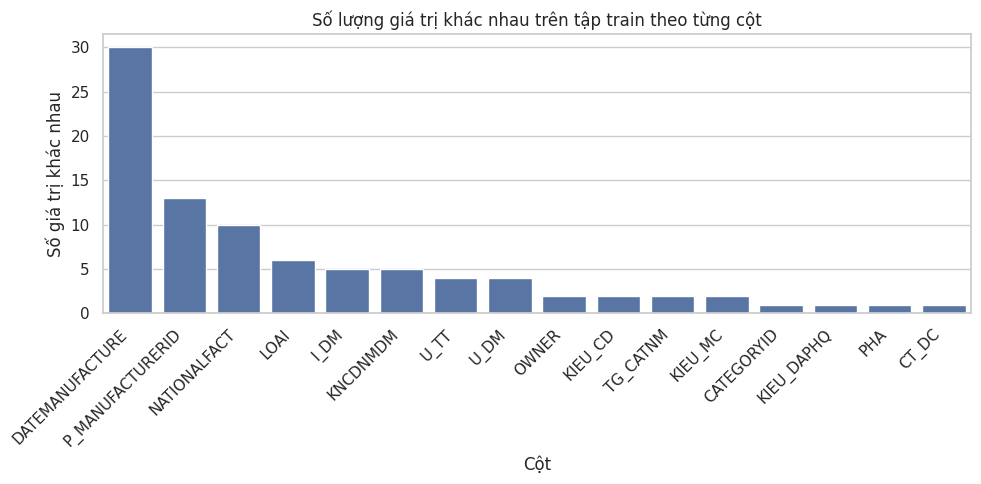

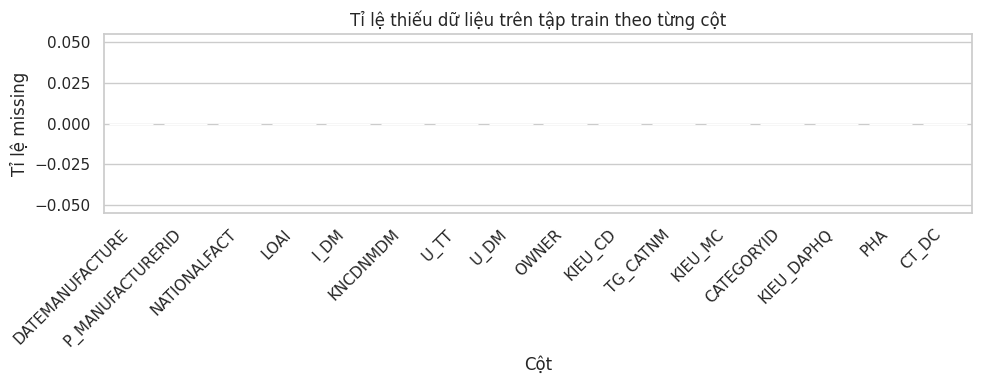

In [29]:
# ============================================================================
# VISUALIZATION 1 - THỐNG KÊ CÁC TRƯỜNG (stats_df)
# ============================================================================

# Biểu đồ số lượng giá trị khác nhau (nunique_train) cho từng cột
plt.figure(figsize=(10, 5))
stats_plot = stats_df.reset_index().rename(columns={"index": "col"})
order = stats_plot.sort_values("nunique_train", ascending=False)["col"]
sns.barplot(data=stats_plot, x="col", y="nunique_train", order=order, color="#4C72B0")
plt.xticks(rotation=45, ha="right")
plt.title("Số lượng giá trị khác nhau trên tập train theo từng cột")
plt.xlabel("Cột")
(plt.gca().set_ylabel("Số giá trị khác nhau"))
plt.tight_layout()
plt.show()

# Biểu đồ tỉ lệ thiếu dữ liệu (missing_rate_train) cho từng cột
plt.figure(figsize=(10, 4))
sns.barplot(data=stats_plot, x="col", y="missing_rate_train", order=order, color="#DD8452")
plt.xticks(rotation=45, ha="right")
plt.title("Tỉ lệ thiếu dữ liệu trên tập train theo từng cột")
plt.xlabel("Cột")
plt.ylabel("Tỉ lệ missing")
plt.tight_layout()
plt.show()


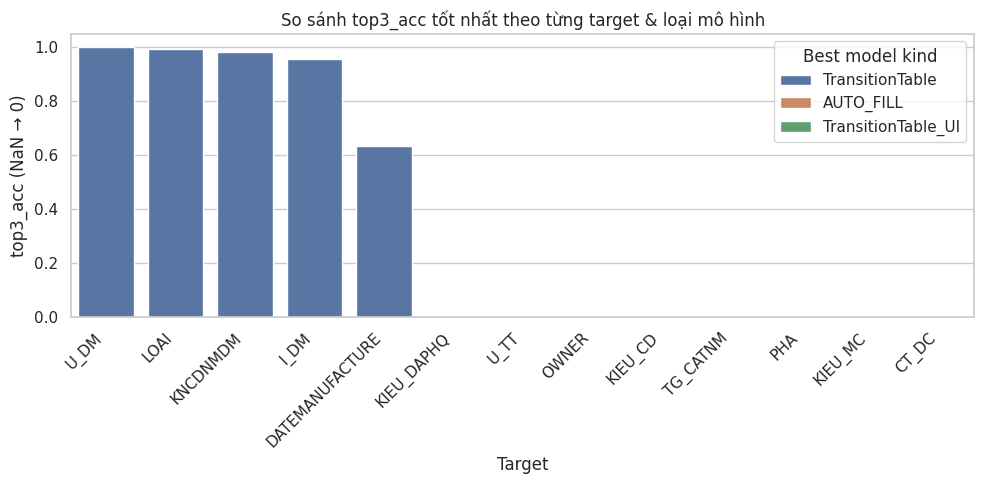

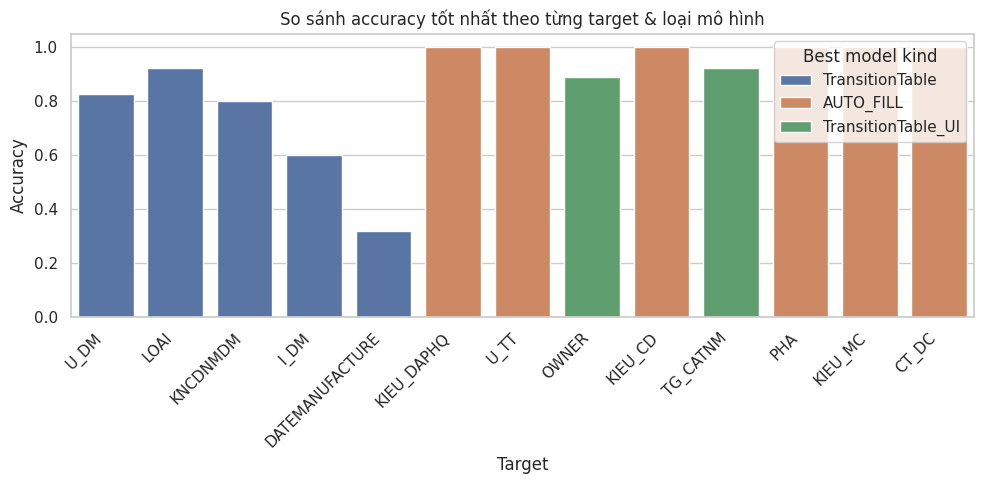

In [30]:
# ============================================================================
# VISUALIZATION 2 - SO SÁNH TOP3_ACC THEO TỪNG TARGET (dựa trên report_df)
# ============================================================================
# Ở bước tổng hợp, mỗi target chỉ giữ lại 1 dòng tốt nhất trong `report_df`.
# Ta vẽ từ report_df để thấy đầy đủ tất cả các target (kể cả target có top3_acc = NaN).

if 'report_df' not in globals():
    print('report_df chưa được tạo, hãy chạy cell tổng hợp (Cell 106) trước.')
else:
    plot_df = report_df.copy()

    # Thay NaN trong top3_acc bằng 0 để vẫn vẽ được cột (dễ so sánh trực quan)
    plot_df['top3_acc_plot'] = plot_df['top3_acc'].fillna(0.0)

    # Sắp xếp theo top3_acc giảm dần
    plot_df = plot_df.sort_values('top3_acc_plot', ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=plot_df, x='target', y='top3_acc_plot', hue='best_kind')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.05)
    plt.xlabel('Target')
    plt.ylabel('top3_acc (NaN → 0)')
    plt.title('So sánh top3_acc tốt nhất theo từng target & loại mô hình')
    plt.legend(title='Best model kind')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.barplot(data=plot_df, x='target', y='acc', hue='best_kind')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.05)
    plt.xlabel('Target')
    plt.ylabel('Accuracy')
    plt.title('So sánh accuracy tốt nhất theo từng target & loại mô hình')
    plt.legend(title='Best model kind')
    plt.tight_layout()
    plt.show()
